In [1]:
# 任务 1：导入必要的库 & 设置
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, KBinsDiscretizer, LabelEncoder
from sklearn.feature_selection import VarianceThreshold
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold 
from pgmpy.estimators import HillClimbSearch, K2Score, BayesianEstimator
from pgmpy.models import BayesianNetwork
from pgmpy.inference import VariableElimination
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns 
import os
from tqdm.notebook import tqdm 
import warnings 

# 设置绘图风格和参数
sns.set_style("whitegrid") # 设置 seaborn 风格
plt.rcParams['figure.figsize'] = (10, 6) # 默认图形大小
plt.rcParams['figure.dpi'] = 100 # 提高分辨率
print(f"设置 Seaborn 绘图风格为: whitegrid")

try:
    plt.rcParams['font.sans-serif'] = ['Arial Unicode MS', 'SimHei', 'Microsoft YaHei', 'sans-serif']
    plt.rcParams['axes.unicode_minus'] = False
    print("尝试设置绘图字体。")
except Exception as e:
    print(f"设置字体失败: {e}。")

# 忽略字体和部分库的警告
warnings.filterwarnings("ignore", message="Glyph .* missing from current font.")
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning, module='sklearn')
warnings.filterwarnings("ignore", category=RuntimeWarning)
print("已设置忽略部分警告信息。")

from lifelines import CoxPHFitter, KaplanMeierFitter
from lifelines.utils import concordance_index
lifelines_installed = True

from pycombat import pycombat
combat_installed = True

设置 Seaborn 绘图风格为: whitegrid
尝试设置绘图字体。
已设置忽略部分警告信息。


In [3]:
# 任务 2：定义文件路径和加载数据
expression_file = "/Users/yaoyue/stat 479/COUNT_Symbol_matrix.csv"
subtype_file = "/Users/yaoyue/stat 479/TCGA_COAD_subtypes.csv" # 使用原始亚型/临床文件
output_visualization_dir = "/Users/yaoyue/stat 479/tcga_visualization" 
if not os.path.exists(output_visualization_dir):
    try:
        os.makedirs(output_visualization_dir)
        print(f"创建输出目录: {output_visualization_dir}")
    except OSError as e:
        print(f"错误：无法创建目录 {output_visualization_dir} : {e}")
        output_visualization_dir = "./tcga_visualization_fallback" # 备用目录
        os.makedirs(output_visualization_dir, exist_ok=True)
        print(f"将使用备用目录保存输出: {output_visualization_dir}")

expression_df_raw = pd.read_csv(expression_file, index_col=0)
print(f"成功从 '{expression_file}' 加载表达数据 ({expression_df_raw.shape})。")

clinical_df_raw = pd.read_csv(subtype_file)

成功从 '/Users/yaoyue/stat 479/COUNT_Symbol_matrix.csv' 加载表达数据 ((59427, 517))。


In [5]:
# 任务 3：数据对齐与准备
expression_df = expression_df_raw.loc[:, (expression_df_raw != 0).any(axis=0)]
expression_df = expression_df.loc[(expression_df_raw != 0).any(axis=1), :]
expression_df.columns = expression_df.columns.str.slice(0, 12) # 标准化样本 ID
expression_df = expression_df.loc[:, ~expression_df.columns.duplicated(keep='first')] # 去重
expression_df_T = expression_df.T # 转置为 样本 x 基因
print(f"表达数据处理后维度 (样本 x 基因): {expression_df_T.shape}")

id_col = 'patient'; # 适配原始文件
if id_col not in clinical_df_raw.columns:
    if 'bcr_patient_barcode' in clinical_df_raw.columns: id_col = 'bcr_patient_barcode'
    elif 'submitter_id' in clinical_df_raw.columns: id_col = 'submitter_id'
    else: print(f"错误：在 '{subtype_file}' 中找不到患者 ID 列。"); exit()
clinical_df = clinical_df_raw.copy()
clinical_df['patient_id_short'] = clinical_df[id_col].str.slice(0, 12)
clinical_df = clinical_df.drop_duplicates(subset=['patient_id_short'], keep='first')
clinical_df = clinical_df.set_index('patient_id_short')
print(f"临床数据处理后维度: {clinical_df.shape}")

print("对齐表达和临床数据...")
common_samples = expression_df_T.index.intersection(clinical_df.index)
if len(common_samples) == 0: print("错误：表达数据和临床数据之间没有共同样本。"); exit()
expression_aligned = expression_df_T.loc[common_samples].copy()
clinical_aligned = clinical_df.loc[common_samples].copy()
print(f"成功找到 {len(common_samples)} 个共同样本进行分析。")

print("查找批次信息列...")
batch_column_name = None
possible_batch_cols = [col for col in clinical_aligned.columns if 'batch' in col.lower() or 'plate' in col.lower() or 'center' in col.lower() or 'tissue_source_site' in col.lower()]
if possible_batch_cols:
    for col_name in possible_batch_cols:
        if clinical_aligned[col_name].nunique() >= 2 and not clinical_aligned[col_name].isnull().all():
             if clinical_aligned[col_name].isnull().sum() <= len(clinical_aligned) * 0.5:
                 batch_column_name = col_name; print(f"找到并选用批次信息列：'{batch_column_name}'。"); break
             else: print(f"警告：列 '{col_name}' 缺失值过多。")
        else: print(f"警告：列 '{col_name}' 唯一值不足或全为空。")
if not batch_column_name: print("警告：未找到合适的批次信息列，将跳过 ComBat。")

表达数据处理后维度 (样本 x 基因): (451, 56539)
临床数据处理后维度: (276, 45)
对齐表达和临床数据...
成功找到 194 个共同样本进行分析。
查找批次信息列...
警告：未找到合适的批次信息列，将跳过 ComBat。



基于 'expression_subtype' 定义上下文
有效上下文: ['MSI/CIMP', 'CIN', 'Invasive']
样本数:
expression_subtype
MSI/CIMP    57
CIN         55
Invasive    36
Name: count, dtype: int64

绘制上下文样本量分布图...
上下文样本量图已保存到 /Users/yaoyue/stat 479/tcga_visualization/context_sample_counts.png


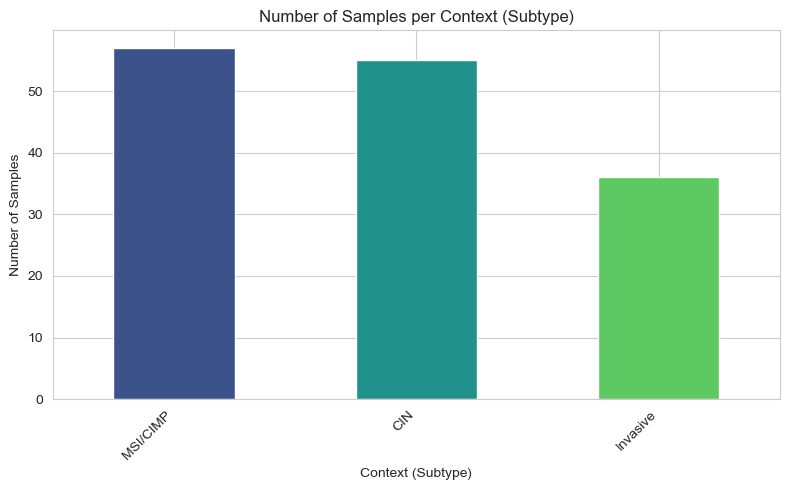

In [7]:
# 任务 4：定义上下文 (Contexts) & 可视化
context_column = 'expression_subtype' # 使用原始文件中的列
min_samples_per_context = 10
contexts = []
context_counts = pd.Series(dtype=int)

if context_column in clinical_aligned.columns and clinical_aligned[context_column].notna().any():
    context_counts = clinical_aligned[context_column].value_counts()
    valid_contexts = context_counts[context_counts >= min_samples_per_context].index.tolist()
    print(f"\n基于 '{context_column}' 定义上下文")
    if not valid_contexts:
        print(f"警告：无样本数足够的上下文(阈值={min_samples_per_context})，用单一上下文。")
        contexts = ['all_samples']; clinical_aligned['context_col_used'] = 'all_samples'; context_column = 'context_col_used'
    else:
        contexts = valid_contexts; print(f"有效上下文: {contexts}"); print("样本数:"); print(context_counts[valid_contexts])
        clinical_aligned['context_col_used'] = clinical_aligned[context_column]; context_column = 'context_col_used'
else:
    print(f"\n警告: 未找到有效上下文列 '{context_column}'。使用单一上下文。")
    contexts = ['all_samples']; clinical_aligned['context_col_used'] = 'all_samples'; context_column = 'context_col_used'

if not context_counts.empty and len(contexts) > 1:
    print("\n绘制上下文样本量分布图...")
    plt.figure(figsize=(8, 5))
    context_counts[contexts].plot(kind='bar', color=sns.color_palette("viridis", len(contexts)))
    plt.title('Number of Samples per Context (Subtype)')
    plt.xlabel('Context (Subtype)'); plt.ylabel('Number of Samples')
    plt.xticks(rotation=45, ha='right'); plt.tight_layout()
    context_count_filename = os.path.join(output_visualization_dir, "context_sample_counts.png")
    try:
        plt.savefig(context_count_filename, dpi=100); print(f"上下文样本量图已保存到 {context_count_filename}"); plt.show()
    except Exception as e: print(f"保存失败: {e}"); plt.close()
else:
    print("只有一个上下文或无有效上下文，不绘制样本量图。")


-- 处理上下文: MSI/CIMP --
样本数: 57
应用了 log1p 转换。
跳过 ComBat: 无批次信息。
应用了 Z-score 标准化。
选择了 23114 个高方差基因。
离散化为 3 个区间 (uniform)。

-- 处理上下文: CIN --
样本数: 55
应用了 log1p 转换。
跳过 ComBat: 无批次信息。
应用了 Z-score 标准化。
选择了 21932 个高方差基因。
离散化为 3 个区间 (uniform)。

-- 处理上下文: Invasive --
样本数: 36
应用了 log1p 转换。
跳过 ComBat: 无批次信息。
应用了 Z-score 标准化。
选择了 17455 个高方差基因。
离散化为 3 个区间 (uniform)。

--- 可视化预处理效果 (以 'MSI/CIMP' 为例) ---
预处理效果图已保存到 /Users/yaoyue/stat 479/tcga_visualization/preprocessing_effect_distribution.png


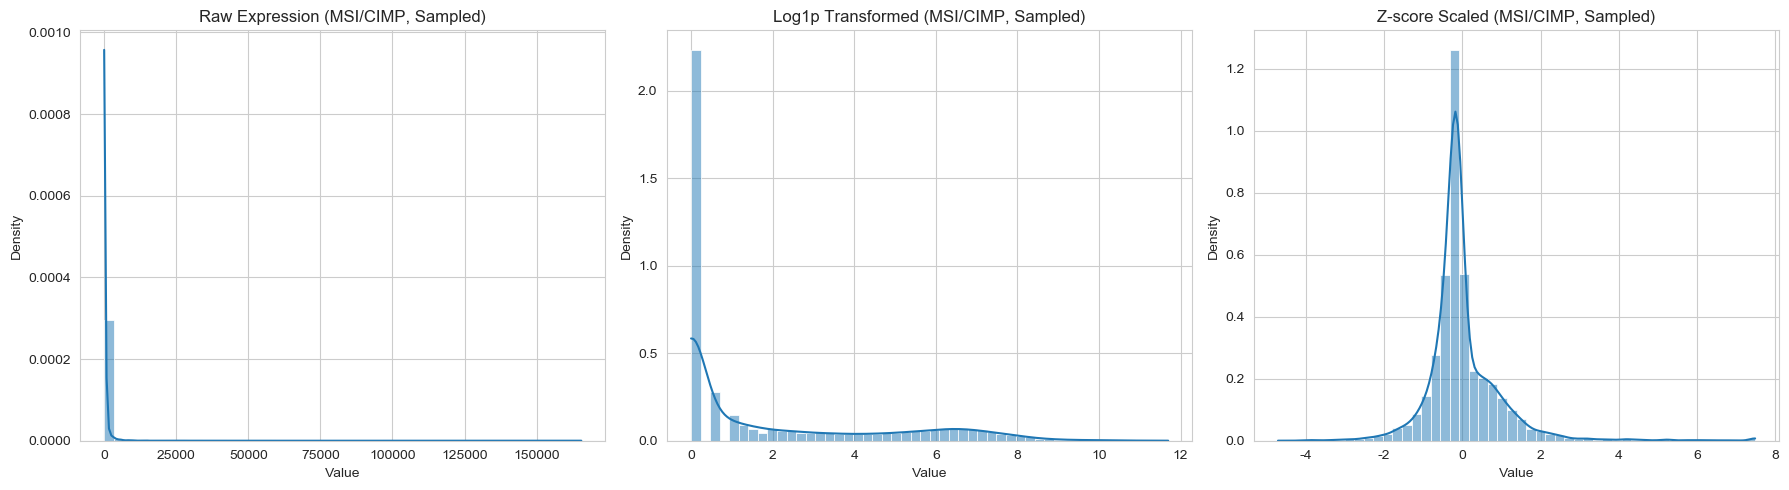


--- 可视化筛选后基因数量 ---
基因筛选数量图已保存为 /Users/yaoyue/stat 479/tcga_visualization/variance_filtering_gene_counts.png


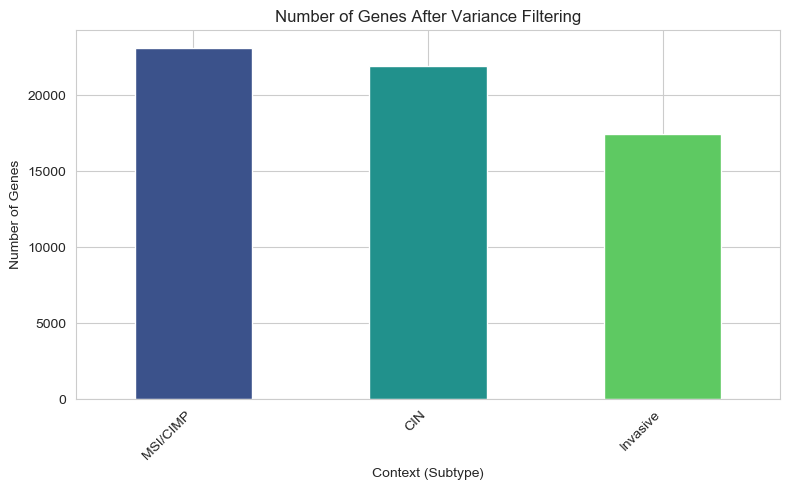

In [13]:
# 任务 5：按上下文进行数据预处理 & 可视化
processed_data_dict = {}
selected_genes_dict = {}
scaled_data_dict = {}
log_corrected_data_dict = {}
genes_selected_counts = {} # 存储筛选后基因数

# 用于绘制预处理效果图的数据 (选第一个上下文为例)
plot_preprocessing = True # 是否绘制预处理图
preprocessing_plot_data = {'raw': np.array([]), 'log': np.array([]), 'scaled': np.array([])} # 使用 numpy array 初始化

min_samples_per_context = 10

# 确保循环外的变量定义没有问题
combat_installed = 'pycombat' in globals() # 检查 pycombat 是否已成功导入
# batch_column_name 在任务3中定义
if 'batch_column_name' not in globals(): batch_column_name = None # 安全检查
if 'clinical_aligned' not in globals() or 'expression_aligned' not in globals():
    print("错误：缺少对齐后的数据(clinical_aligned/expression_aligned)，请先运行任务3。")
    # exit() # 或者根据您的环境决定是否退出
if 'contexts' not in globals() or 'context_column' not in globals():
     print("错误：缺少上下文信息(contexts/context_column)，请先运行任务4。")
     # exit()

# 开始上下文循环
for i, context in enumerate(contexts):
    print(f"\n-- 处理上下文: {context} --")
    if context_column not in clinical_aligned.columns:
        print(f"错误：上下文列 '{context_column}' 在对齐后的临床数据中不存在。跳过上下文 '{context}'。")
        continue

    context_samples_idx = clinical_aligned[clinical_aligned[context_column] == context].index

    if len(context_samples_idx) < min_samples_per_context:
        print(f"跳过: 样本数不足 (<{min_samples_per_context})")
        continue

    valid_expression_samples = context_samples_idx.intersection(expression_aligned.index)
    if len(valid_expression_samples) < min_samples_per_context:
         print(f"跳过: 表达数据匹配样本不足 (<{min_samples_per_context})")
         continue

    expression_context = expression_aligned.loc[valid_expression_samples].copy()
    print(f"样本数: {len(expression_context)}")

    expression_context_numeric = expression_context.apply(pd.to_numeric, errors='coerce').fillna(0)

    # 存储原始数据分布 (抽样)
    if i == 0 and plot_preprocessing:
        raw_flat = expression_context_numeric.values.flatten(); sample_size = min(len(raw_flat), 20000)
        if sample_size > 0: preprocessing_plot_data['raw'] = np.random.choice(raw_flat, sample_size, replace=False)

    # 1. Log 转换
    expression_log = np.log1p(expression_context_numeric)
    print("应用了 log1p 转换。")
    if i == 0 and plot_preprocessing:
        log_flat = expression_log.values.flatten(); sample_size = min(len(log_flat), 20000)
        if sample_size > 0: preprocessing_plot_data['log'] = np.random.choice(log_flat, sample_size, replace=False)

    # 2. 批次效应校正 (尝试)
    expression_corrected = expression_log
    if combat_installed and batch_column_name:
        if batch_column_name in clinical_aligned.columns:
            batch_info = clinical_aligned.loc[valid_expression_samples, batch_column_name].dropna()
            batch_info_aligned = batch_info[batch_info.notna()]
            if len(batch_info_aligned.index) >= 5 and batch_info_aligned.nunique() >= 2:
                expression_log_aligned = expression_log.loc[batch_info_aligned.index]
                expression_log_T = expression_log_aligned.T
                print(f"应用 ComBat (样本数: {len(batch_info_aligned)}, 批次数: {batch_info_aligned.nunique()})...")
                try:
                    expression_corrected_T = pycombat(expression_log_T, batch_info_aligned)
                    expression_corrected = expression_corrected_T.T
                    print("ComBat 完成。")
                except Exception as e:
                    print(f"ComBat 执行失败: {e}。")
                    expression_corrected = expression_log # 回退
            else:
                print("跳过 ComBat: 样本/批次信息不足。")
        else:
             print(f"跳过 ComBat: 批次列 '{batch_column_name}' 不存在。")
    else:
         if not combat_installed: print("跳过 ComBat: 未安装或导入失败。")
         elif not batch_column_name: print("跳过 ComBat: 无批次信息。")
    log_corrected_data_dict[context] = expression_corrected

    # 3. Z-score 标准化
    scaler = StandardScaler()
    expression_scaled = pd.DataFrame() # 初始化
    try:
        if expression_corrected.shape[1] == 0: raise ValueError("批次校正后无数据")
        expression_scaled_np = scaler.fit_transform(expression_corrected)
        expression_scaled = pd.DataFrame(expression_scaled_np,
                                         index=expression_corrected.index,
                                         columns=expression_corrected.columns)
        scaled_data_dict[context] = expression_scaled
        print("应用了 Z-score 标准化。")
        if i == 0 and plot_preprocessing:
            scaled_flat = expression_scaled.values.flatten(); sample_size = min(len(scaled_flat), 20000)
            if sample_size > 0: preprocessing_plot_data['scaled'] = np.random.choice(scaled_flat, sample_size, replace=False)
    except ValueError as e:
        print(f"上下文 '{context}' Z-score 标准化出错: {e}。跳过此上下文的后续步骤。")
        if context in log_corrected_data_dict: del log_corrected_data_dict[context]
        continue

    # 4. 特征选择
    variance_threshold = 1.0
    expression_selected = pd.DataFrame() # 初始化
    try:
        if expression_scaled.empty: raise ValueError("之前的标准化步骤失败，无数据进行特征选择")
        expression_scaled_clean = expression_scaled.fillna(0)
        if expression_scaled_clean.shape[1] == 0: raise ValueError("标准化后无数据")
        variance_selector = VarianceThreshold(threshold=variance_threshold)
        expression_selected_np = variance_selector.fit_transform(expression_scaled_clean.values)
        selected_genes = expression_scaled_clean.columns[variance_selector.get_support()]
        if expression_selected_np.shape[1] == 0:
             print(f"警告：无基因通过方差阈值 {variance_threshold}。")
             n_top_variance = 500
             top_variance_genes = expression_scaled_clean.var().nlargest(n_top_variance).index
             expression_selected = expression_scaled_clean[top_variance_genes]
             selected_genes = top_variance_genes
             print(f"保留方差 Top {n_top_variance} 基因。")
             if expression_selected.shape[1] == 0:
                  print(f"跳过：无有效特征可选。")
                  if context in scaled_data_dict: del scaled_data_dict[context]
                  if context in log_corrected_data_dict: del log_corrected_data_dict[context]
                  continue
        else:
            expression_selected = pd.DataFrame(expression_selected_np, index=expression_scaled_clean.index, columns=selected_genes)
        print(f"选择了 {len(selected_genes)} 个高方差基因。")
        selected_genes_dict[context] = selected_genes.tolist()
        genes_selected_counts[context] = len(selected_genes)
    except Exception as e:
        print(f"上下文 '{context}' 方差阈值处理出错: {e}。跳过此上下文的后续步骤。")
        if context in scaled_data_dict: del scaled_data_dict[context]
        if context in log_corrected_data_dict: del log_corrected_data_dict[context]
        continue

    # 5. 离散化
    n_bins = 3
    discretizer = KBinsDiscretizer(n_bins=n_bins, encode='ordinal', strategy='uniform', subsample=None) # 使用 uniform 避免之前的警告
    try:
        if expression_selected.empty or expression_selected.shape[1] == 0: raise ValueError("没有特征选择后的数据可以离散化")
        expression_discretized_np = discretizer.fit_transform(expression_selected.values)
        expression_discretized = pd.DataFrame(expression_discretized_np.astype(int), columns=expression_selected.columns, index=expression_selected.index)
        processed_data_dict[context] = expression_discretized
        print(f"离散化为 {n_bins} 个区间 (uniform)。")
    except ValueError as e:
        print(f"上下文 '{context}' 离散化失败: {e}。跳过此上下文的后续步骤。")
        if context in selected_genes_dict: del selected_genes_dict[context]
        if context in scaled_data_dict: del scaled_data_dict[context]
        if context in log_corrected_data_dict: del log_corrected_data_dict[context]
        continue
# 循环结束

# --- 可视化预处理效果 ---
if plot_preprocessing and contexts and preprocessing_plot_data['raw'].size > 0:
    print(f"\n--- 可视化预处理效果 (以 '{contexts[0]}' 为例) ---")
    plt.figure(figsize=(18, 5))
    plot_titles = {'raw': f'Raw Expression ({contexts[0]}, Sampled)',
                   'log': f'Log1p Transformed ({contexts[0]}, Sampled)',
                   'scaled': f'Z-score Scaled ({contexts[0]}, Sampled)'}
    for i, (key, data) in enumerate(preprocessing_plot_data.items()):
        if data.size > 0:
             plt.subplot(1, 3, i+1)
             sns.histplot(data, kde=True, bins=50, stat="density")
             plt.title(plot_titles[key])
             plt.xlabel("Value"); plt.ylabel("Density")
    plt.tight_layout()
    preprocess_filename = os.path.join(output_visualization_dir, "preprocessing_effect_distribution.png")
    try: plt.savefig(preprocess_filename, dpi=100); print(f"预处理效果图已保存到 {preprocess_filename}"); plt.show()
    except Exception as e: print(f"保存预处理图失败: {e}"); plt.close()

# --- 可视化筛选后基因数量 ---
if genes_selected_counts:
     print("\n--- 可视化筛选后基因数量 ---")
     plt.figure(figsize=(8, 5))
     genes_counts_series = pd.Series(genes_selected_counts)
     genes_counts_series.plot(kind='bar', color=sns.color_palette("viridis", len(genes_counts_series)))
     plt.title('Number of Genes After Variance Filtering'); plt.xlabel('Context (Subtype)'); plt.ylabel('Number of Genes')
     plt.xticks(rotation=45, ha='right'); plt.tight_layout()
     filter_count_filename = os.path.join(output_visualization_dir, "variance_filtering_gene_counts.png")
     try: plt.savefig(filter_count_filename, dpi=100); print(f"基因筛选数量图已保存为 {filter_count_filename}"); plt.show()
     except Exception as e: print(f"保存基因筛选图失败: {e}"); plt.close()

学习网络:   0%|          | 0/3 [00:00<?, ?it/s]


-- 学习上下文: MSI/CIMP --
基因数量 (23114) > 50，进行特征选择。
为结构学习选择 Top 50 基因。
开始结构学习 (Hill Climb)...
结构学习完成: 50 个节点 (用于拟合), 46 条边。
开始参数学习 (Bayesian Estimator)...
上下文 'MSI/CIMP' 参数学习完成。

-- 学习上下文: CIN --
基因数量 (21932) > 50，进行特征选择。
为结构学习选择 Top 50 基因。
开始结构学习 (Hill Climb)...
结构学习完成: 50 个节点 (用于拟合), 67 条边。
开始参数学习 (Bayesian Estimator)...
上下文 'CIN' 参数学习完成。

-- 学习上下文: Invasive --
基因数量 (17455) > 50，进行特征选择。
为结构学习选择 Top 50 基因。
开始结构学习 (Hill Climb)...
结构学习完成: 50 个节点 (用于拟合), 45 条边。
开始参数学习 (Bayesian Estimator)...
上下文 'Invasive' 参数学习完成。

--- 所有用于 BN 建模的基因列表 (背景基因集) ---
共 148 个基因。
完整的背景基因 R 向量已保存到: /Users/yaoyue/stat 479/tcga_visualization/background_genes.txt
# 请从此文件中复制内容到 R 代码的 background_genes 变量。

--- 各上下文网络规模总结 ---
          Nodes  Edges
MSI/CIMP     50     46
CIN          50     67
Invasive     50     45
网络规模总结图已保存为 /Users/yaoyue/stat 479/tcga_visualization/network_size_summary.png


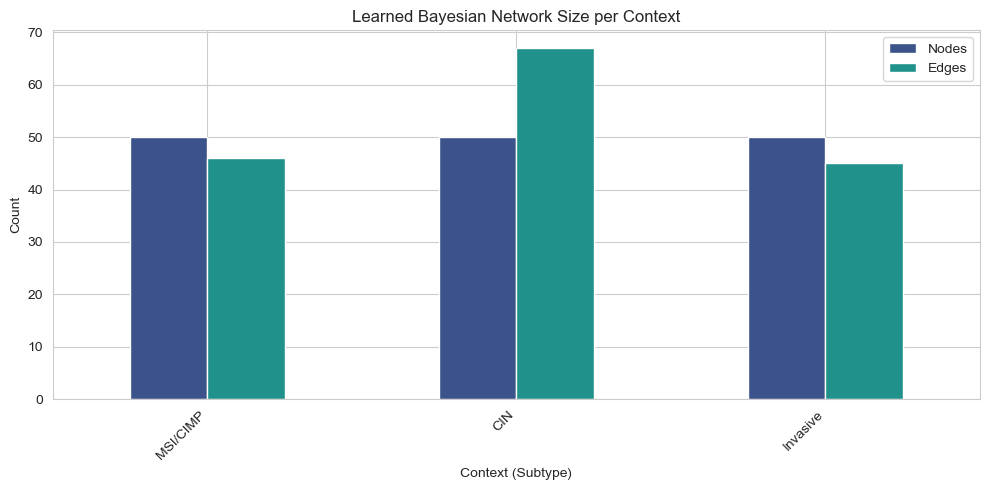

In [17]:
# 任务 6：学习情境化贝叶斯网络 & 可视化总结
learned_models = {}
learned_structures = {}
all_selected_genes = set() # 初始化用于存储所有模型基因的集合
max_genes_for_structure_learning = 50
network_summary = {} # 存储节点和边的数量

for context, data_discrete in tqdm(processed_data_dict.items(), desc="学习网络"):
    print(f"\n-- 学习上下文: {context} --")
    if data_discrete.empty or data_discrete.shape[1] == 0:
         print(f"跳过上下文 '{context}'，无有效数据。")
         continue

    genes_in_context = data_discrete.columns.tolist()
    if len(genes_in_context) > max_genes_for_structure_learning:
        print(f"基因数量 ({len(genes_in_context)}) > {max_genes_for_structure_learning}，进行特征选择。")
        if context in scaled_data_dict and all(g in scaled_data_dict[context].columns for g in genes_in_context):
            variance_context = scaled_data_dict[context][genes_in_context].var()
            # 检查方差是否全为0或NaN
            if variance_context.notna().sum() == 0 or variance_context.max() == 0:
                 top_genes_context = np.random.choice(genes_in_context, max_genes_for_structure_learning, replace=False).tolist()
                 print(f"警告：无法基于方差选择（可能方差为0或NaN），随机选择 {max_genes_for_structure_learning} 基因。")
            else:
                 top_genes_context = variance_context.nlargest(max_genes_for_structure_learning).index.tolist()
                 print(f"为结构学习选择 Top {max_genes_for_structure_learning} 基因。")
        else:
            top_genes_context = np.random.choice(genes_in_context, max_genes_for_structure_learning, replace=False).tolist()
            print(f"警告：标准化数据不可用或基因不匹配，随机选择 {max_genes_for_structure_learning} 基因。")
        # 确保选择的基因在离散数据中存在
        top_genes_context = [gene for gene in top_genes_context if gene in data_discrete.columns]
        if len(top_genes_context) < 2 : # 至少需要2个基因才能学结构
             print(f"跳过上下文 '{context}'，选择的有效基因数不足 (<2)。")
             continue
        data_for_bn = data_discrete[top_genes_context].copy()
    else:
        data_for_bn = data_discrete.copy()
        print(f"使用全部 {len(genes_in_context)} 个选定基因进行结构学习。")

    if data_for_bn.shape[0] < 5:
        print(f"跳过上下文 '{context}'，样本数 ({data_for_bn.shape[0]}) 过少。")
        continue

    current_genes = data_for_bn.columns.tolist()
    all_selected_genes.update(current_genes) # 更新包含所有模型基因的集合

    print("开始结构学习 (Hill Climb)...")
    scoring_method = K2Score(data=data_for_bn)
    hc = HillClimbSearch(data=data_for_bn)
    try:
        best_model_structure = hc.estimate(scoring_method=scoring_method, max_indegree=2, epsilon=1e-4, max_iter=100, show_progress=False)
        edges = best_model_structure.edges()
        learned_structures[context] = edges
        num_edges = len(edges)
        # 获取实际模型节点（可能包含因结构学习未连接而被忽略，但后续添加的孤立节点）
        model_nodes_in_struct = set(best_model_structure.nodes()) # 结构学习得到的节点
        final_model_nodes = set(data_for_bn.columns) # 所有用于拟合的节点
        num_nodes = len(final_model_nodes) # 最终节点数应为输入数据的列数
        print(f"结构学习完成: {num_nodes} 个节点 (用于拟合), {num_edges} 条边。")

        print("开始参数学习 (Bayesian Estimator)...")
        bn_model = BayesianNetwork(edges)
        # 添加在数据中但结构中可能缺失的孤立节点
        missing_nodes_in_struct = final_model_nodes - model_nodes_in_struct
        if missing_nodes_in_struct:
            bn_model.add_nodes_from(list(missing_nodes_in_struct))
            print(f"添加了 {len(missing_nodes_in_struct)} 个孤立节点到模型中。")
            num_nodes = len(bn_model.nodes()) # 确认最终模型节点数

        # 拟合参数
        bn_model.fit(data_for_bn, estimator=BayesianEstimator, prior_type="BDeu", equivalent_sample_size=5)
        learned_models[context] = bn_model
        print(f"上下文 '{context}' 参数学习完成。")
        network_summary[context] = {'Nodes': num_nodes, 'Edges': num_edges} # 存储摘要

    except Exception as e:
        print(f"上下文 '{context}' BN 学习出错: {e}")
        if context in learned_structures:
             del learned_structures[context] # 如果出错，移除结构
        continue # 跳到下一个 context
# 循环结束

# 打印背景基因列表并保存到文件
print("\n--- 所有用于 BN 建模的基因列表 (背景基因集) ---")
background_gene_list = sorted(list(all_selected_genes))
if background_gene_list:
    print(f"共 {len(background_gene_list)} 个基因。")
    # 格式化为 R 向量字符串
    quoted_background_genes = [f'"{gene}"' for gene in background_gene_list]
    joined_quoted_background = ", ".join(quoted_background_genes)
    r_vector_string = f"background_genes <- c({joined_quoted_background})"

    # 定义保存路径和文件名 (确保 output_visualization_dir 已定义)
    if 'output_visualization_dir' not in globals(): output_visualization_dir = "." # 备用路径
    background_filename = os.path.join(output_visualization_dir, "background_genes.txt")
    try:
        with open(background_filename, 'w') as f:
            f.write(r_vector_string)
        print(f"完整的背景基因 R 向量已保存到: {background_filename}")
        print("# 请从此文件中复制内容到 R 代码的 background_genes 变量。")
    except Exception as e:
        print(f"错误：无法将背景基因列表写入文件 {background_filename}: {e}")
        print("# 请手动复制以下列表（如果 Notebook 未截断）：")
        print(r_vector_string) # 作为后备，仍然打印
else:
    print("未能收集到用于建模的基因列表。")

# 可视化网络规模总结 
if network_summary:
    summary_df = pd.DataFrame.from_dict(network_summary, orient='index')
    print("\n--- 各上下文网络规模总结 ---")
    print(summary_df)
    # 绘图前检查 DataFrame 是否为空
    if not summary_df.empty:
        plt.figure(figsize=(10, 5))
        try:
            summary_df.plot(kind='bar', ax=plt.gca(), color=sns.color_palette("viridis", len(summary_df)))
            plt.title('Learned Bayesian Network Size per Context')
            plt.xlabel('Context (Subtype)')
            plt.ylabel('Count')
            plt.xticks(rotation=45, ha='right')
            plt.tight_layout()
            network_size_filename = os.path.join(output_visualization_dir, "network_size_summary.png")
            plt.savefig(network_size_filename, dpi=100)
            print(f"网络规模总结图已保存为 {network_size_filename}")
            plt.show()
        except Exception as e:
            print(f"绘制或保存网络规模图失败: {e}")
            plt.close() # 确保关闭图形
    else:
        print("网络规模摘要数据为空，无法绘图。")
else:
    print("未能生成网络规模摘要。")


-- 可视化上下文的网络: MSI/CIMP --
节点数: 49
边数: 46
网络结构图已保存为 /Users/yaoyue/stat 479/tcga_visualization/network_structure_MSI_CIMP.png


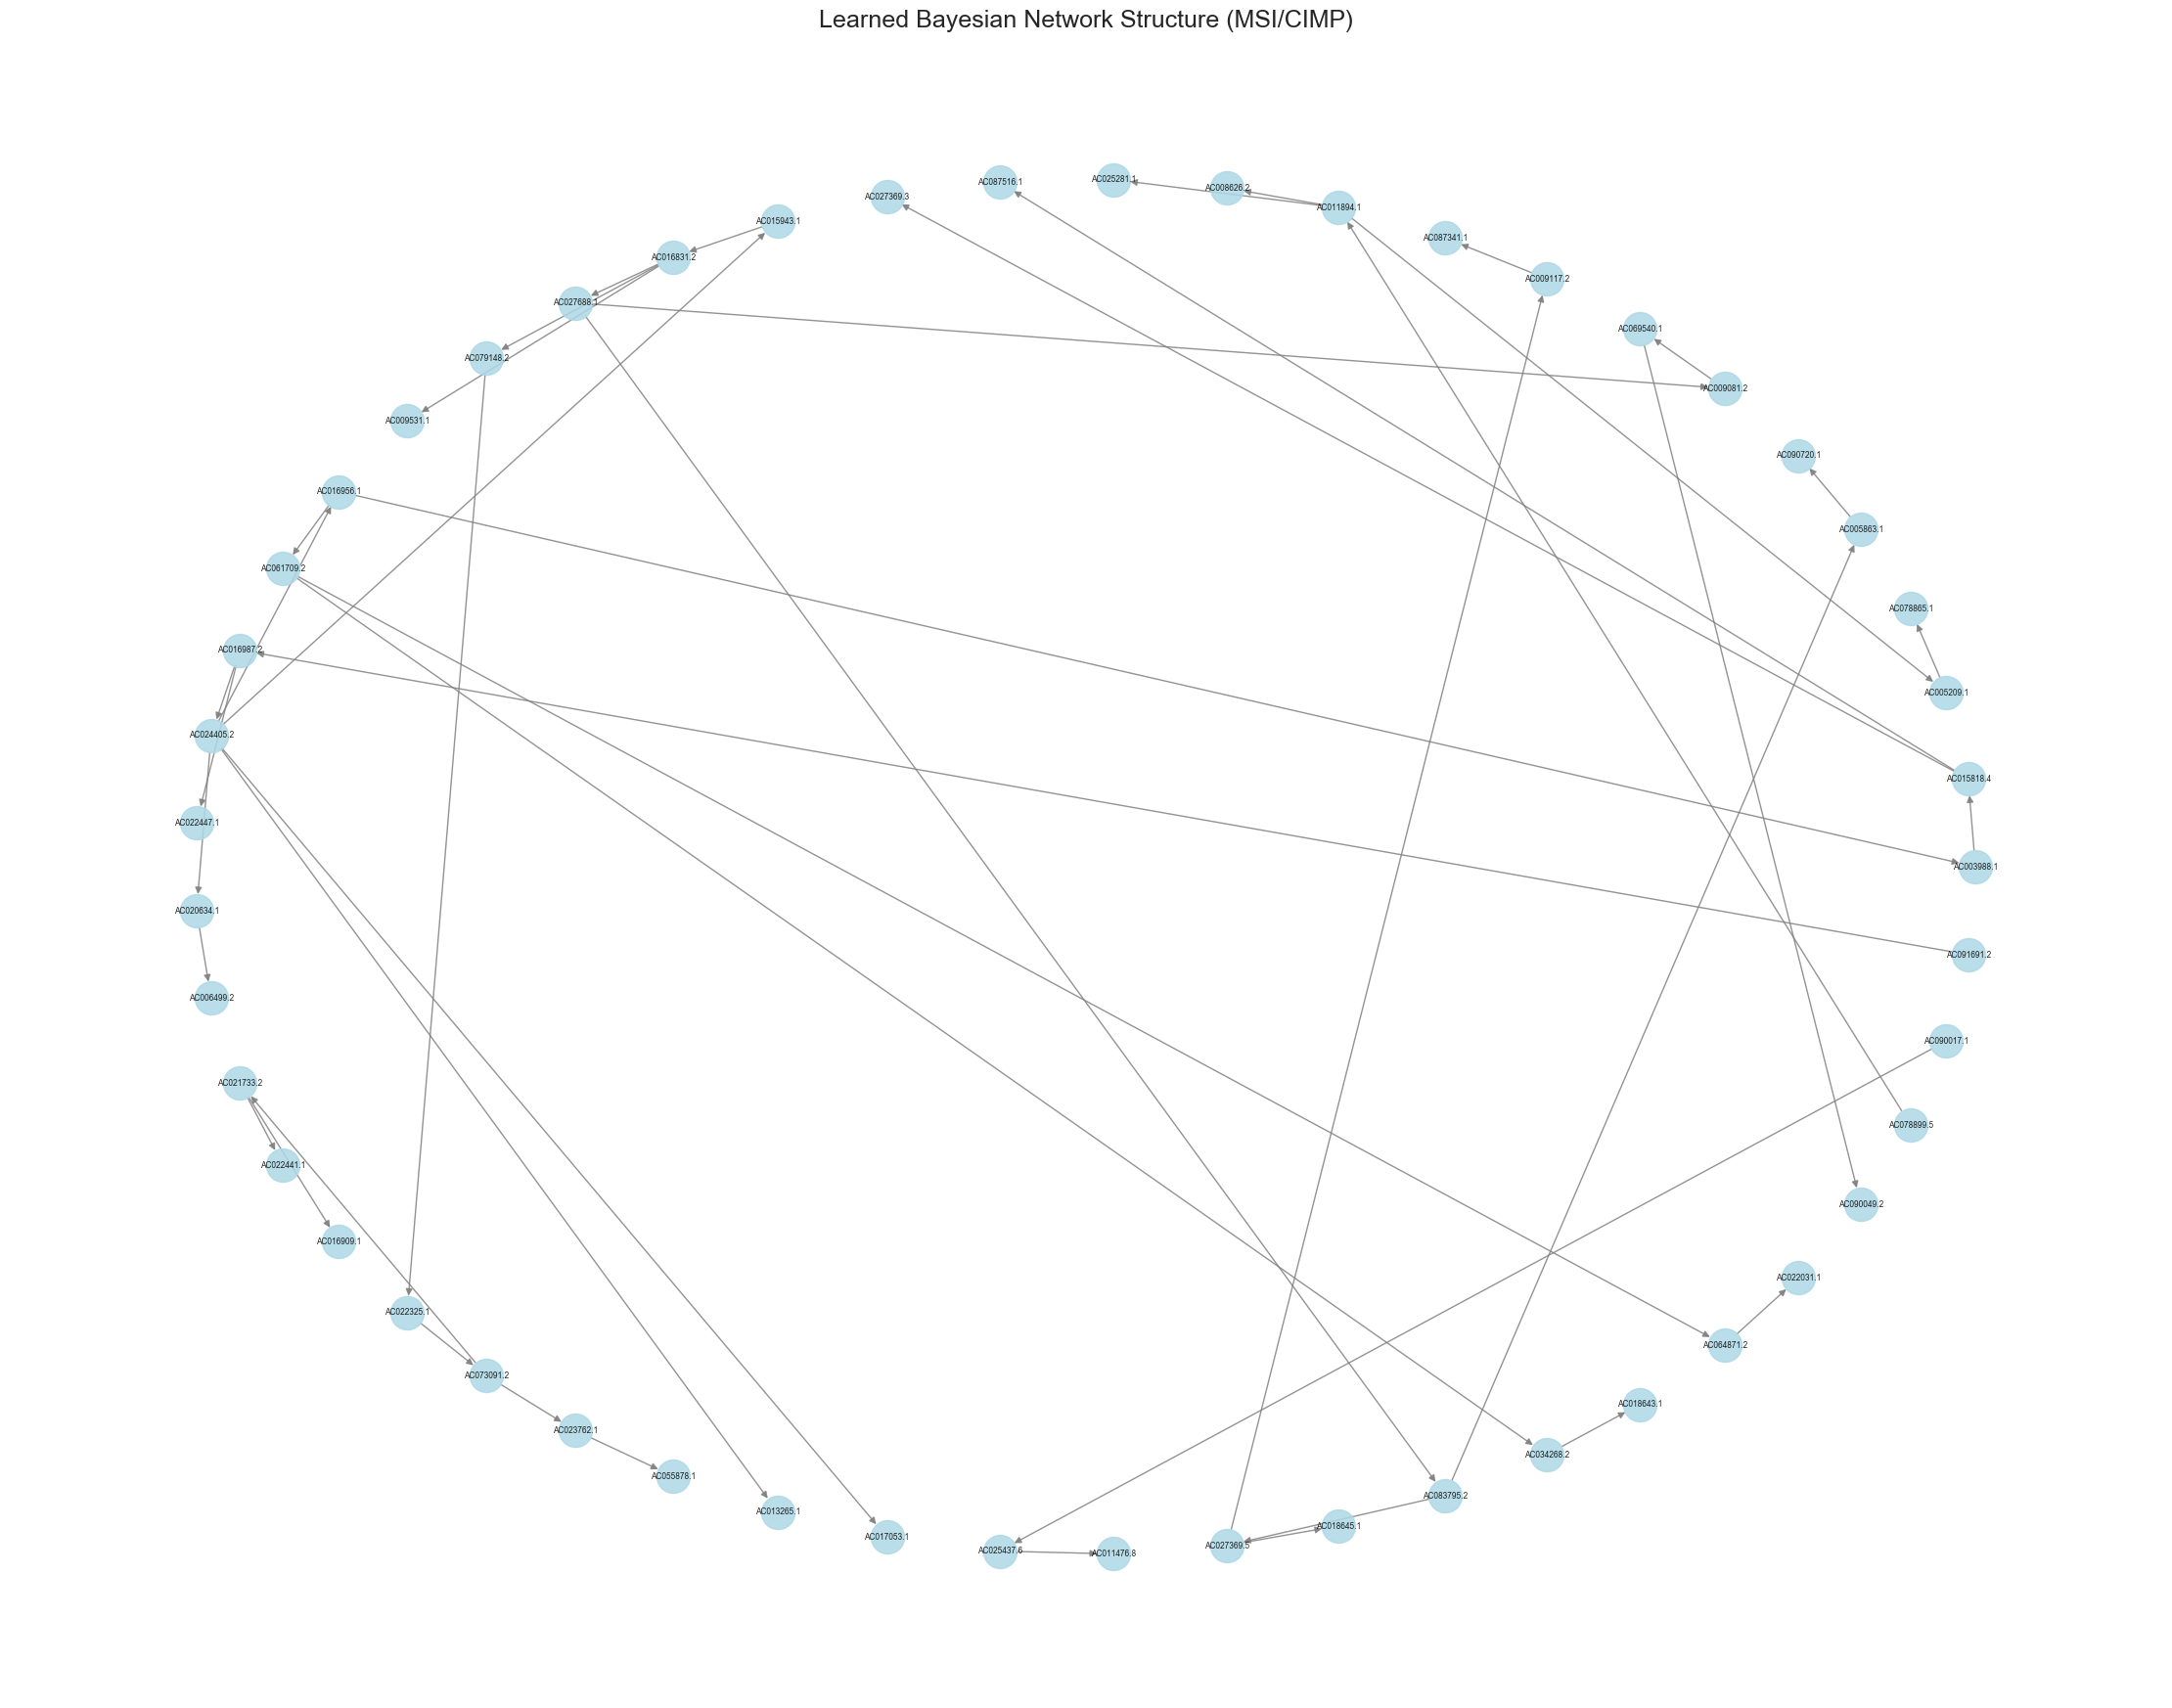


-- 可视化上下文的网络: CIN --
节点数: 50
边数: 67
网络结构图已保存为 /Users/yaoyue/stat 479/tcga_visualization/network_structure_CIN.png


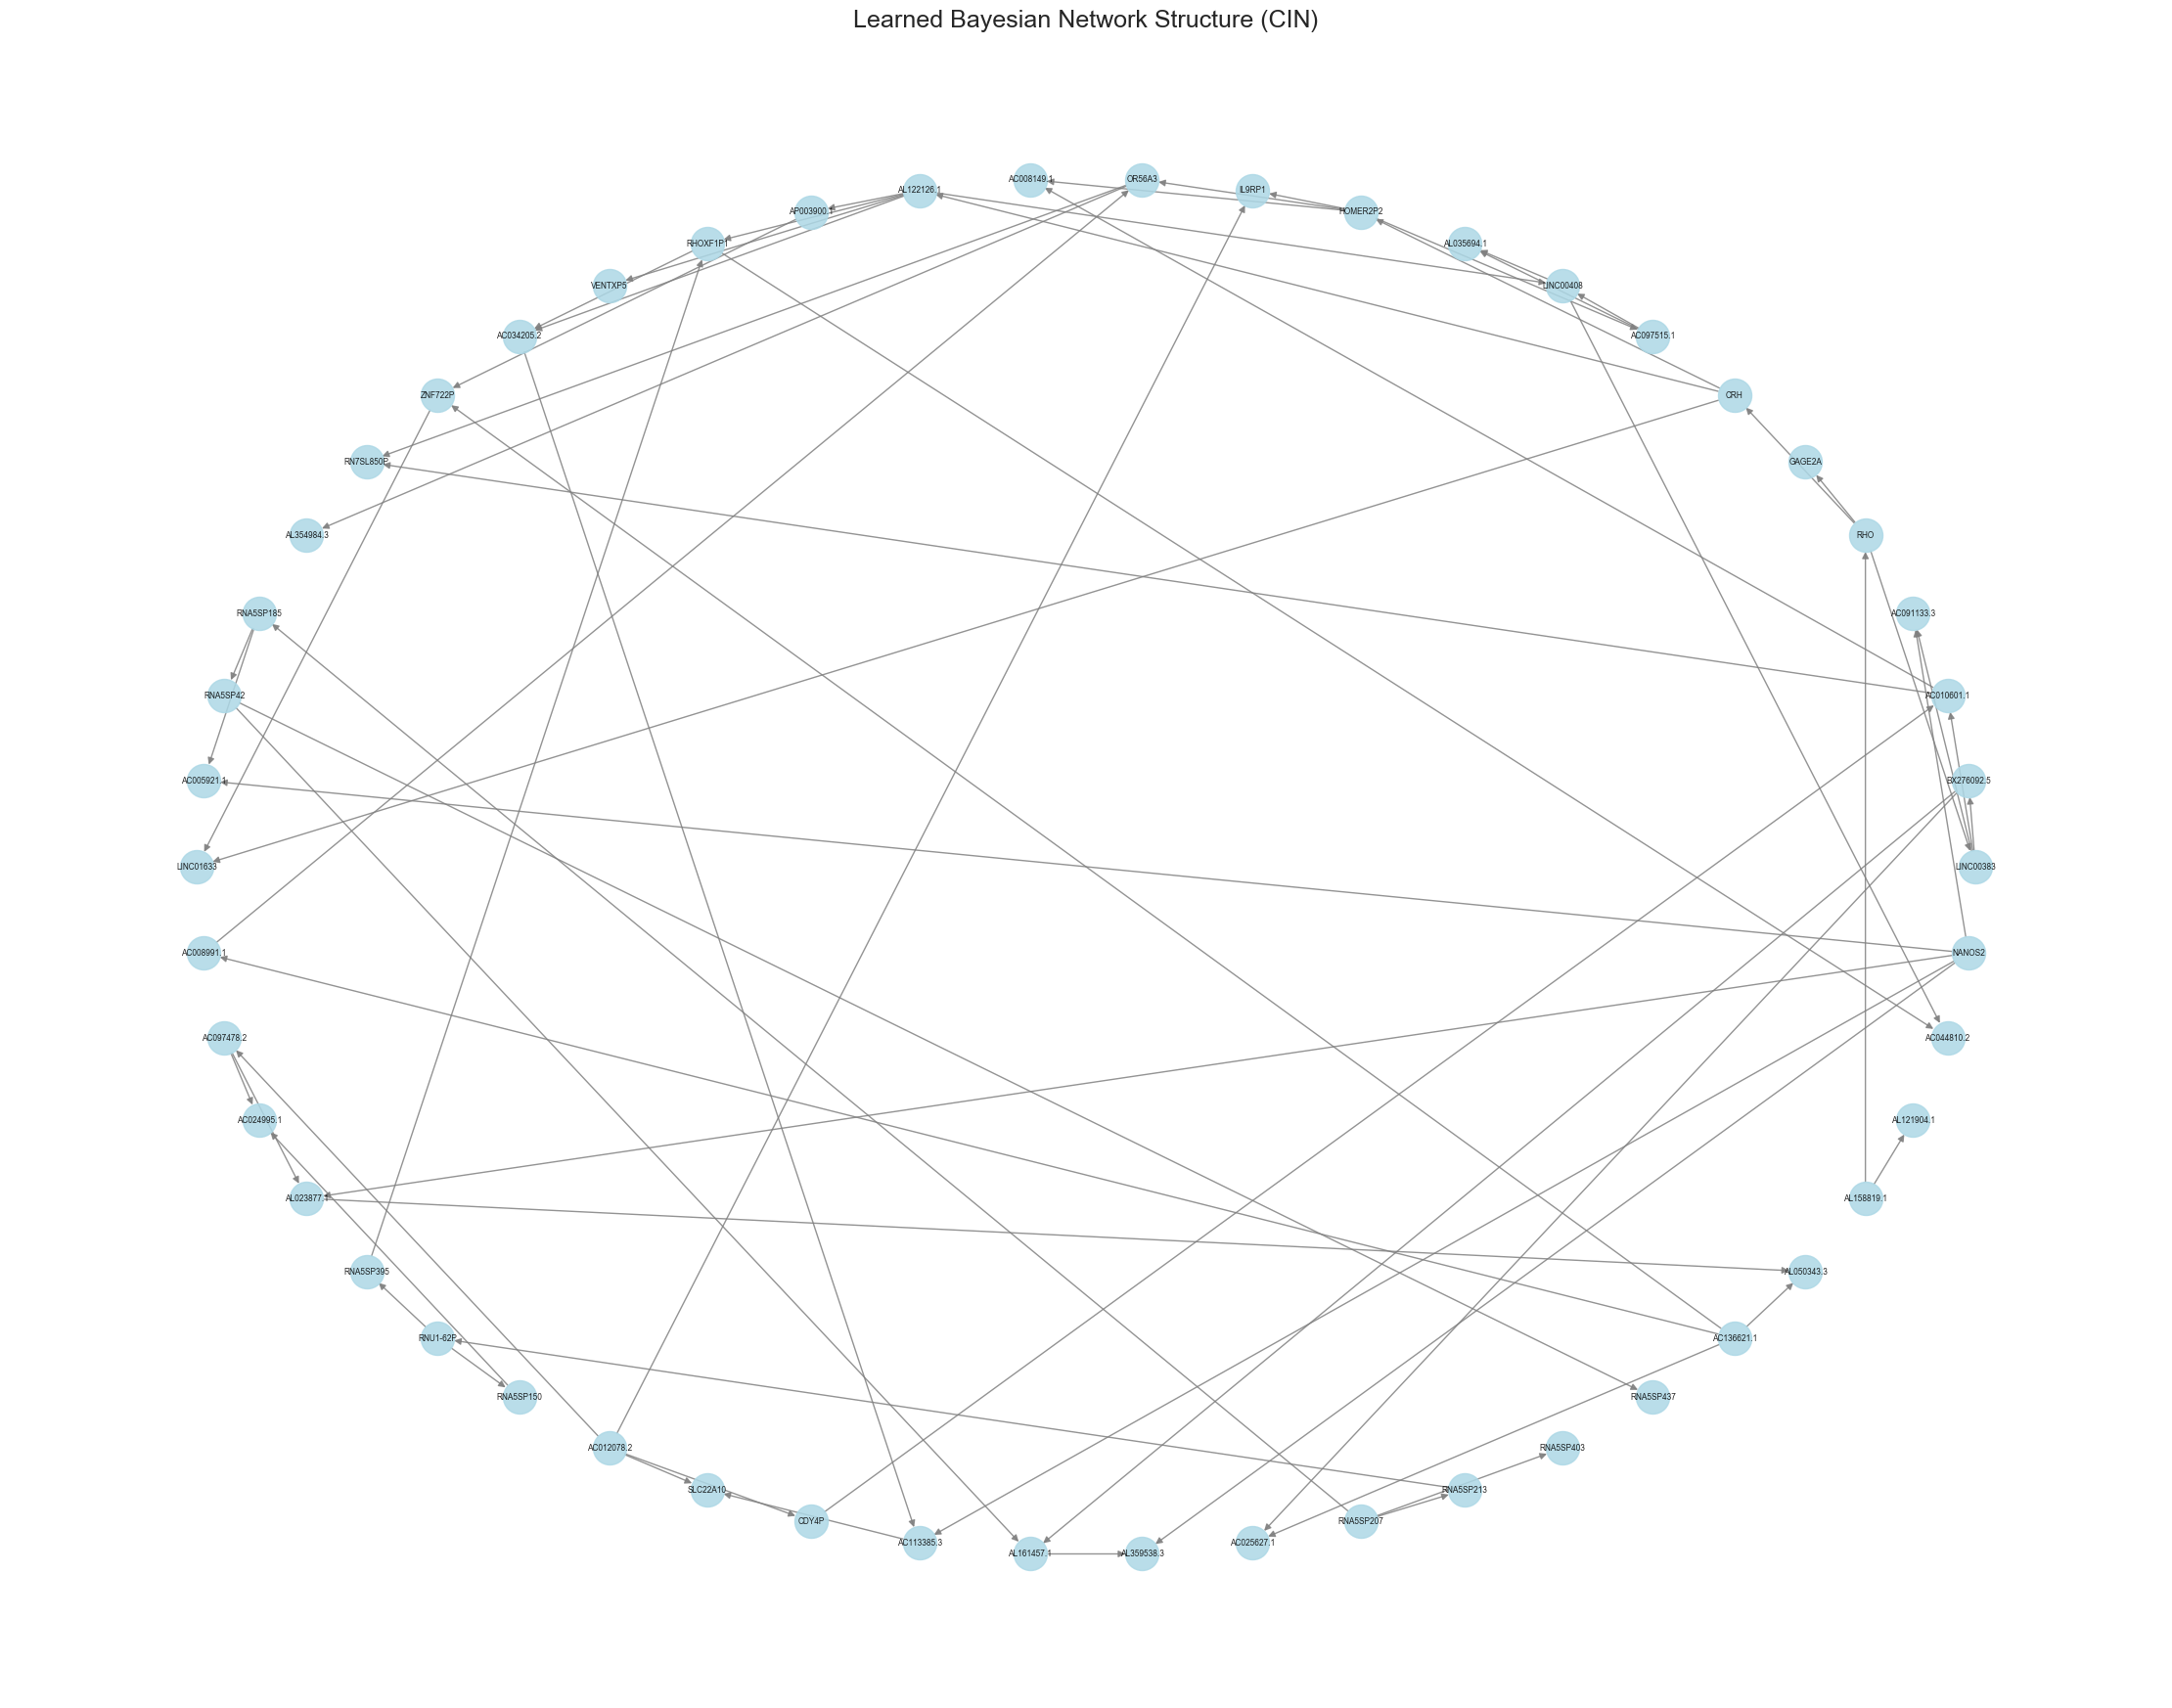


-- 可视化上下文的网络: Invasive --
节点数: 49
边数: 45
网络结构图已保存为 /Users/yaoyue/stat 479/tcga_visualization/network_structure_Invasive.png


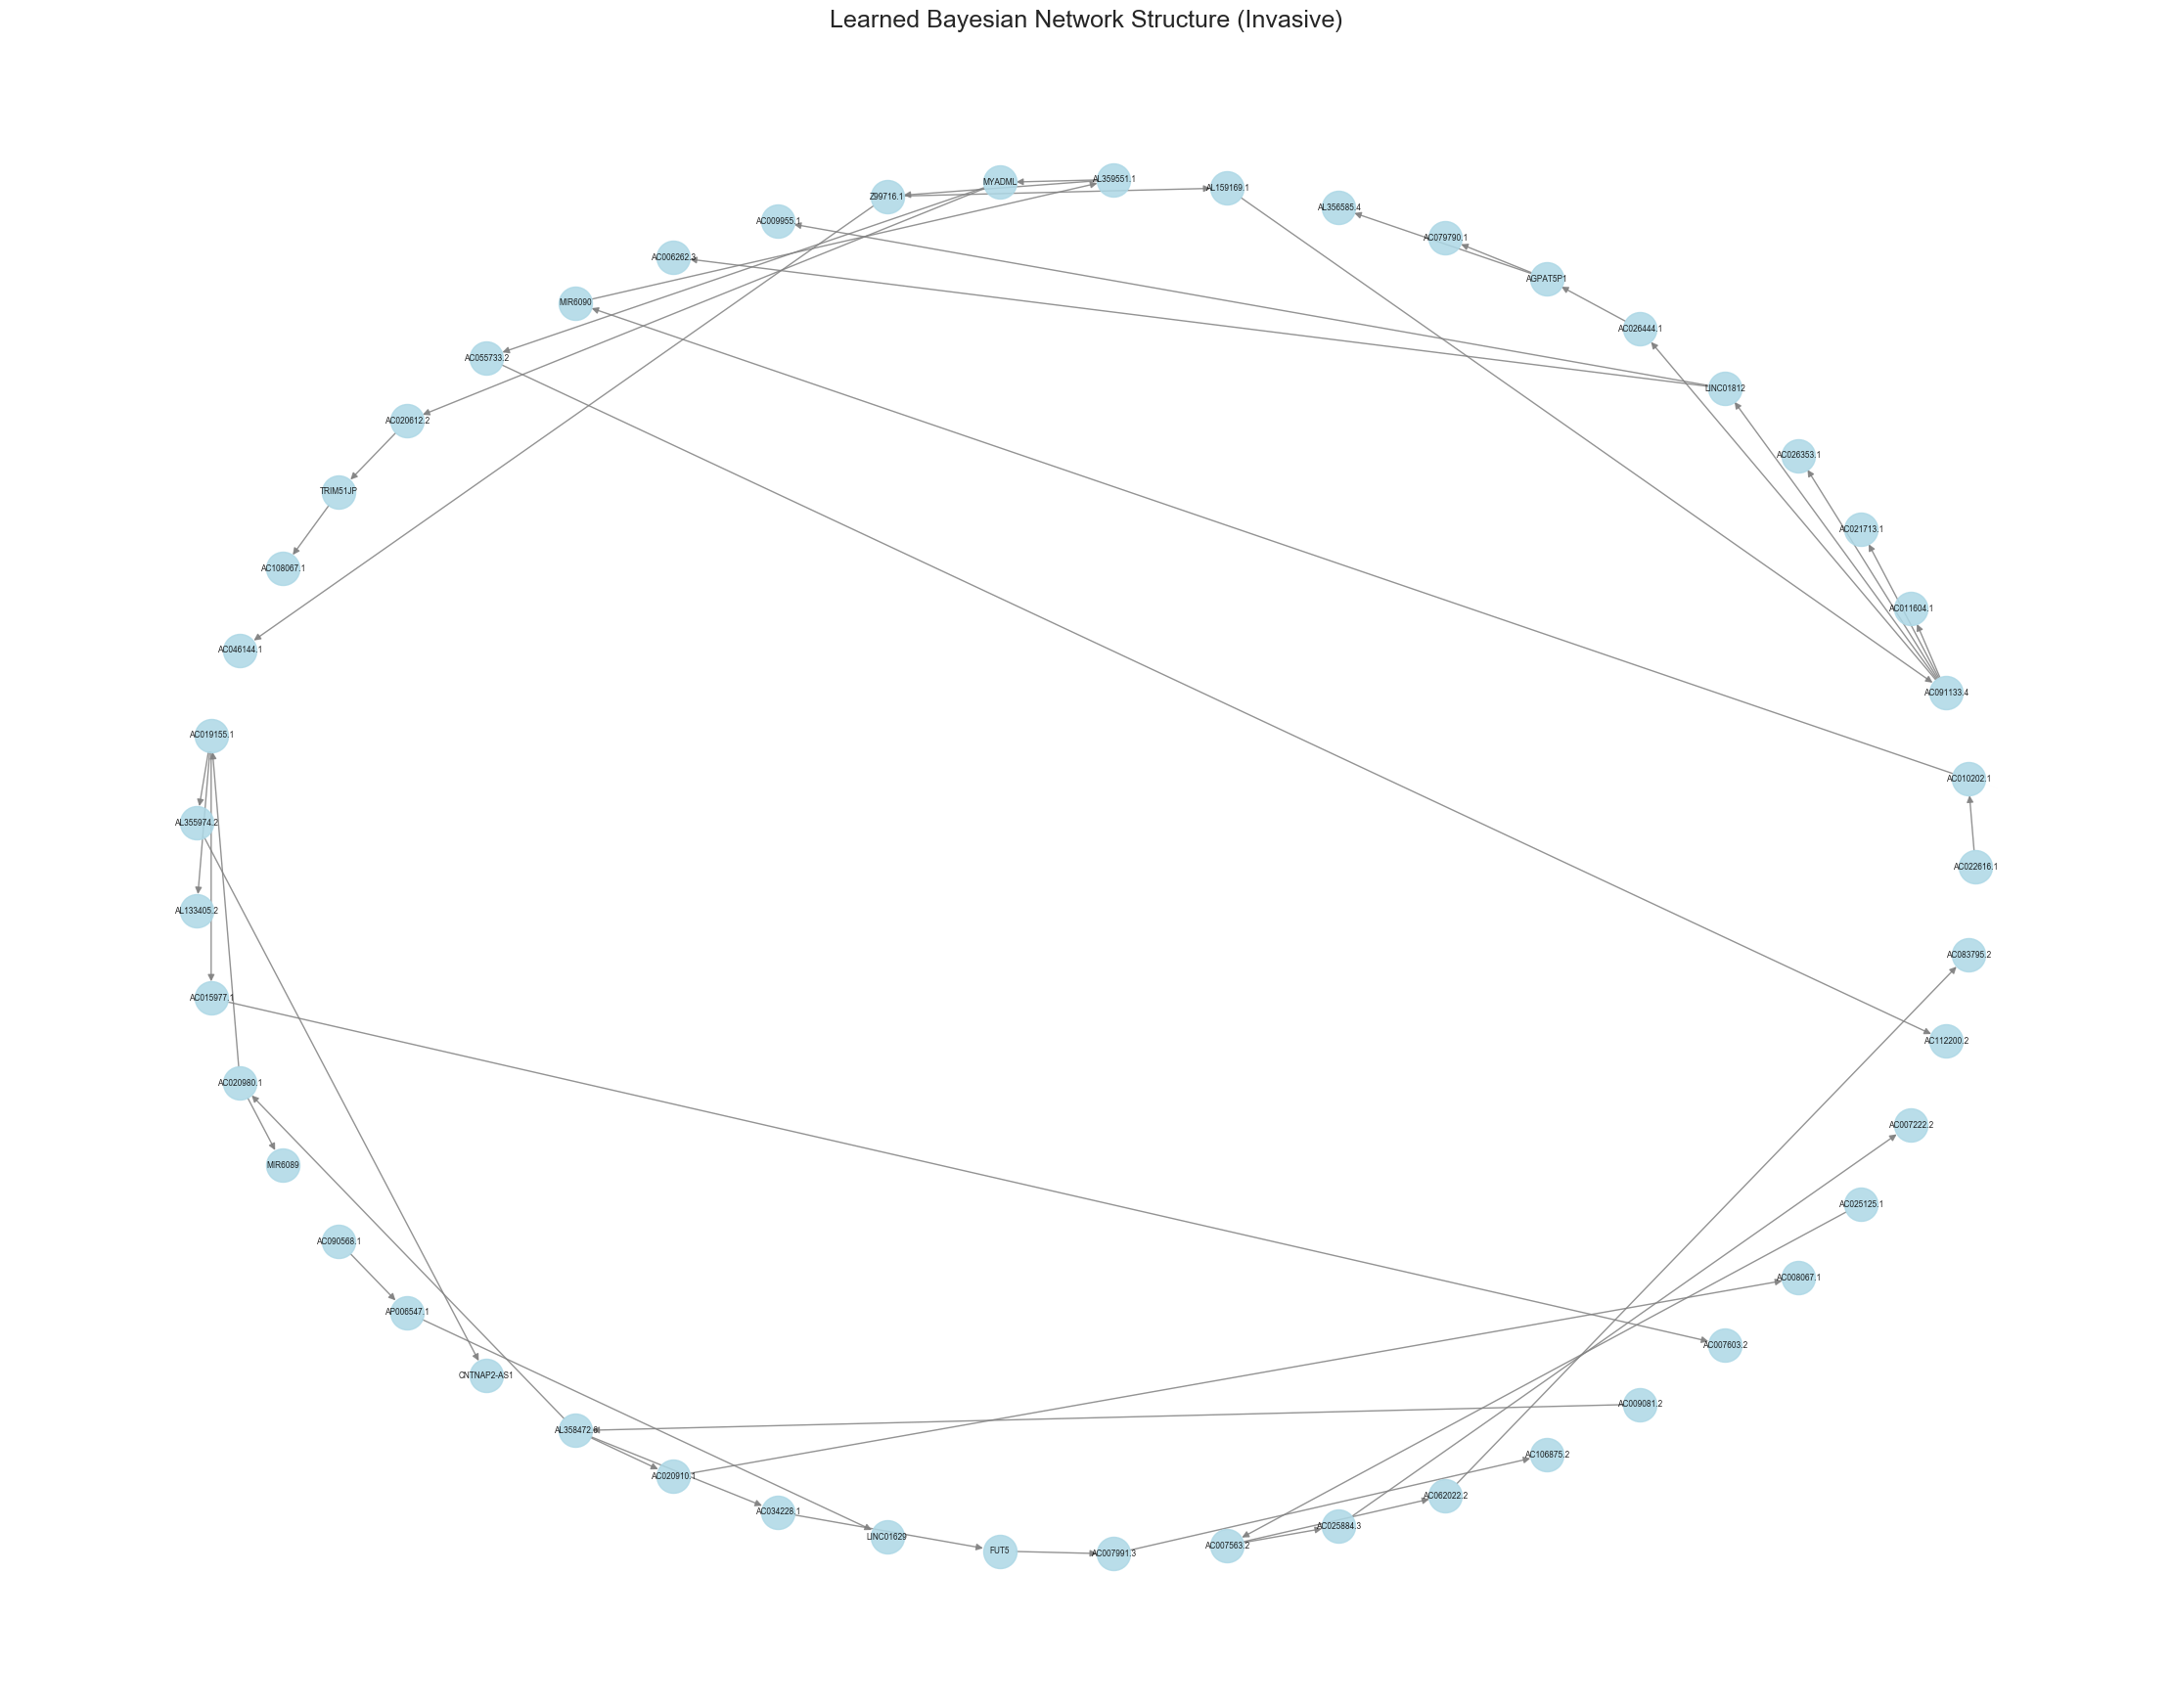


-- 上下文网络结构比较 (Jaccard 相似度) --
相似度热力图已保存为 /Users/yaoyue/stat 479/tcga_visualization/network_jaccard_similarity.png


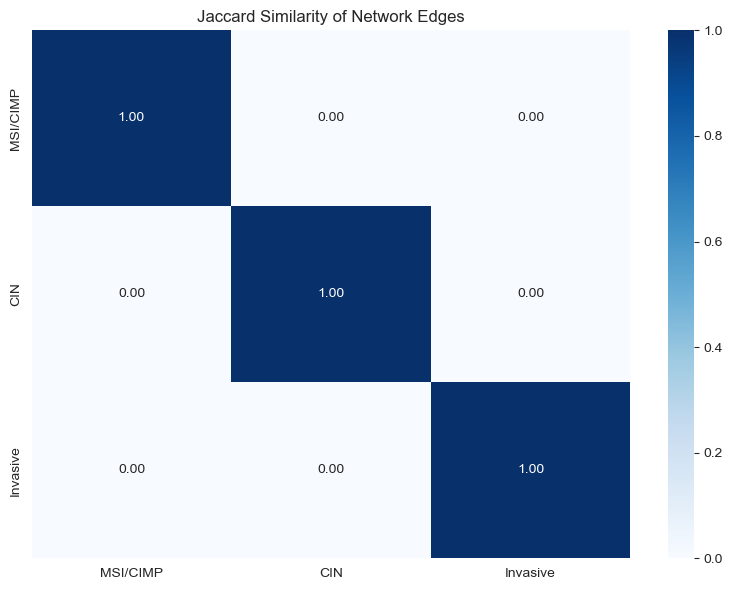

In [19]:
# 任务 7: 网络结构推断与可视化
if learned_models:
    for context, model_to_plot in learned_models.items():
        print(f"\n-- 可视化上下文的网络: {context} --")
        if not model_to_plot.nodes(): print(f"模型无节点。"); continue
        print(f"节点数: {len(model_to_plot.nodes())}"); print(f"边数: {len(model_to_plot.edges())}")
        plt.figure(figsize=(22, 17));
        try:
            pos = nx.kamada_kawai_layout(model_to_plot)
            nx.draw(model_to_plot, pos, with_labels=True, node_size=600, node_color="lightblue", font_size=6, arrowsize=10, alpha=0.85, edge_color='gray', font_family='sans-serif')
            plt.title(f"Learned Bayesian Network Structure ({context})", fontsize=18)
            safe_context_name = str(context).replace('/', '_').replace('\\', '_').replace(':', '_'); plot_filename = os.path.join(output_visualization_dir, f"network_structure_{safe_context_name}.png")
            plt.savefig(plot_filename, dpi=150, bbox_inches='tight'); print(f"网络结构图已保存为 {plot_filename}"); plt.show()
        except Exception as e: print(f"绘图失败: {e}"); plt.close()
    if len(learned_models) > 1:
        print("\n-- 上下文网络结构比较 (Jaccard 相似度) --")
        contexts_list = list(learned_models.keys())
        if not learned_structures or len(learned_structures) != len(learned_models): print("警告：结构信息不完整。")
        else:
            similarity_matrix = pd.DataFrame(index=contexts_list, columns=contexts_list, dtype=float)
            for i, ctx1 in enumerate(contexts_list):
                edges1 = set(learned_structures.get(ctx1, []))
                for j, ctx2 in enumerate(contexts_list):
                    if i <= j: edges2 = set(learned_structures.get(ctx2, [])); intersection = len(edges1.intersection(edges2)); union = len(edges1.union(edges2)); jaccard = 1.0 if union == 0 and i == j else (intersection / union if union != 0 else 0.0); similarity_matrix.loc[ctx1, ctx2] = jaccard; similarity_matrix.loc[ctx2, ctx1] = jaccard
            plt.figure(figsize=(8, 6)); sns.heatmap(similarity_matrix, annot=True, cmap="Blues", fmt=".2f", vmin=0, vmax=1); plt.title("Jaccard Similarity of Network Edges"); plt.tight_layout()
            heatmap_filename = os.path.join(output_visualization_dir, "network_jaccard_similarity.png")
            try: plt.savefig(heatmap_filename, dpi=100, bbox_inches='tight'); print(f"相似度热力图已保存为 {heatmap_filename}"); plt.show()
            except Exception as e: print(f"保存热力图失败: {e}"); plt.close()
else: print("\n无模型，无法可视化。")

计算每个上下文网络的节点度中心性...

-- 分析上下文: MSI/CIMP --
Top 20 Hub 基因 (基于度中心性) 示例: ['AC024405.2', 'AC016831.2', 'AC011894.1', 'AC027688.1', 'AC073091.2', 'AC027369.5', 'AC021733.2', 'AC015818.4', 'AC016987.2', 'AC061709.2']...

-- 分析上下文: CIN --
Top 20 Hub 基因 (基于度中心性) 示例: ['AL122126.1', 'NANOS2', 'HOMER2P2', 'LINC00408', 'AC136621.1', 'AC012078.2', 'RHOXF1P1', 'OR56A3', 'LINC00383', 'CRH']...

-- 分析上下文: Invasive --
Top 20 Hub 基因 (基于度中心性) 示例: ['AC091133.4', 'AL358472.6', 'AC019155.1', 'AC020980.1', 'AL359551.1', 'LINC01812', 'AGPAT5P1', 'Z99716.1', 'MYADML', 'AC007563.2']...

--- 可视化节点度中心性分布 ---
中心性分布图已保存为 /Users/yaoyue/stat 479/tcga_visualization/node_centrality_distribution.png


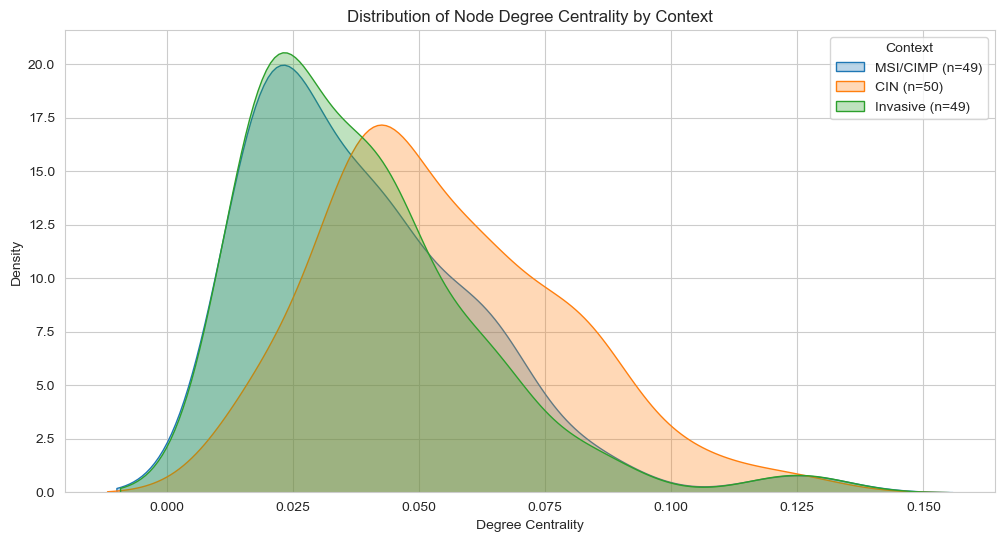


--- 可视化 Top 5 Hub 基因度中心性比较 ---
Top 5 Hub 基因中心性值:
            MSI/CIMP       CIN  Invasive
AC011894.1  0.083333       NaN       NaN
AC016831.2  0.083333       NaN       NaN
AC019155.1       NaN       NaN  0.083333
AC020980.1       NaN       NaN  0.062500
AC024405.2  0.125000       NaN       NaN
AC027688.1  0.062500       NaN       NaN
AC073091.2  0.062500       NaN       NaN
AC091133.4       NaN       NaN  0.125000
AC136621.1       NaN  0.081633       NaN
AL122126.1       NaN  0.122449       NaN
AL358472.6       NaN       NaN  0.083333
AL359551.1       NaN       NaN  0.062500
HOMER2P2         NaN  0.102041       NaN
LINC00408        NaN  0.081633       NaN
NANOS2           NaN  0.102041       NaN
Top Hub 中心性比较图已保存为 /Users/yaoyue/stat 479/tcga_visualization/top5_hub_centrality_comparison.png


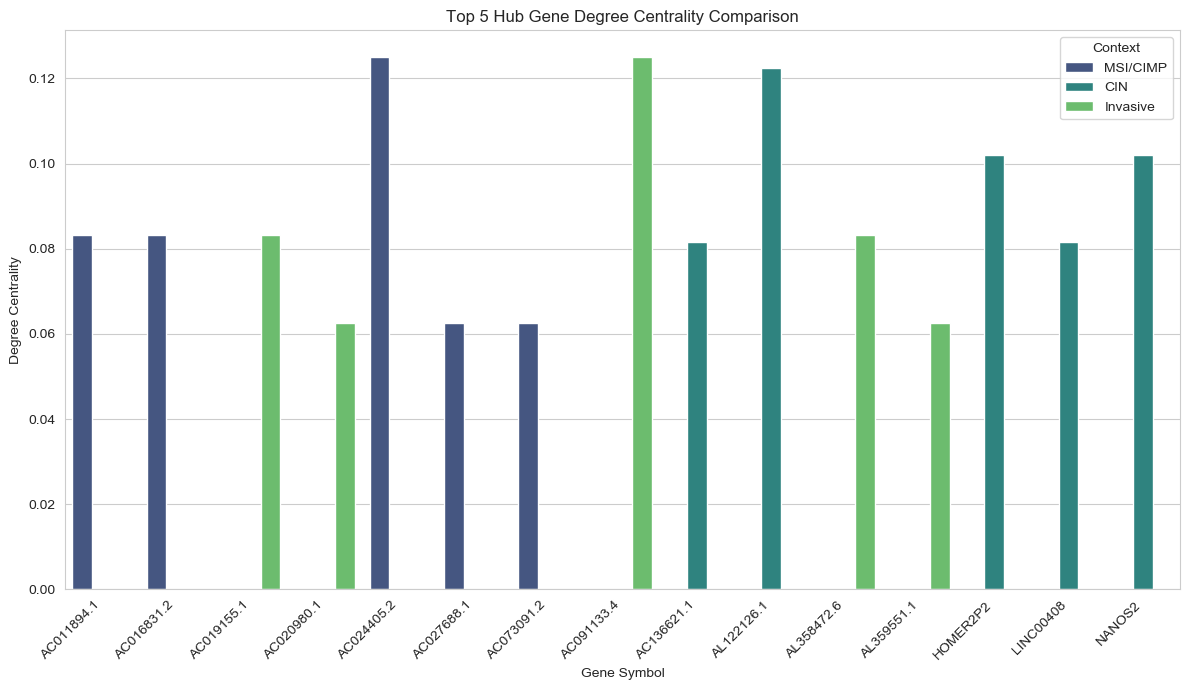


--- Top 20 Hub 基因比较 ---
'MSI/CIMP' vs 'CIN': 共享 Hub 基因数 = 0
'MSI/CIMP' vs 'Invasive': 共享 Hub 基因数 = 0
'CIN' vs 'Invasive': 共享 Hub 基因数 = 0

--- 将每个上下文独有的 Top Hub 基因保存到文件 (R 格式) ---
上下文 'MSI/CIMP' 的独有 Hub 基因 R 向量已保存到: /Users/yaoyue/stat 479/tcga_visualization/MSI_CIMP_Unique_Hubs.txt
上下文 'CIN' 的独有 Hub 基因 R 向量已保存到: /Users/yaoyue/stat 479/tcga_visualization/CIN_Unique_Hubs.txt
上下文 'Invasive' 的独有 Hub 基因 R 向量已保存到: /Users/yaoyue/stat 479/tcga_visualization/Invasive_Unique_Hubs.txt


In [29]:
# 任务 12 (新)：深入网络分析 - 中心性与 Hub 基因比较 + 分布可视化
if 'learned_models' in globals() and learned_models and 'output_visualization_dir' in globals():
    print("计算每个上下文网络的节点度中心性...")
    hub_genes_per_context = {}
    centrality_per_context = {}
    n_top_hubs = 20
    top_hub_centralities = {} # 用于存储 Top 5 Hub 的中心性值

    for context, model in learned_models.items():
        print(f"\n-- 分析上下文: {context} --")
        if not model.nodes():
            print("模型没有节点，跳过。")
            continue
        try:
            G = model.to_undirected()
            G.add_nodes_from(model.nodes()) # 确保包含所有节点

            if not G.nodes():
                 print("创建的 NetworkX 图没有节点，跳过。")
                 continue

            # 计算度中心性
            degree_centrality = nx.degree_centrality(G)

            if not degree_centrality: # 检查是否为空字典
                 print("未能计算度中心性。")
                 continue

            centrality_series = pd.Series(degree_centrality).sort_values(ascending=False)
            centrality_per_context[context] = centrality_series # 存储完整列表

            # 获取 Top N Hub 基因及其中心性
            top_n_series = centrality_series.head(n_top_hubs)
            top_hubs = top_n_series.index.tolist()
            hub_genes_per_context[context] = top_hubs
            top_hub_centralities[context] = top_n_series.head(5) # 存储 Top 5

            print(f"Top {n_top_hubs} Hub 基因 (基于度中心性) 示例: {top_hubs[:10]}...")

        except Exception as e:
            print(f"在上下文 '{context}' 计算中心性或提取 Hub 基因时出错: {e}")

    # 可视化中心性分布 
    print("\n--- 可视化节点度中心性分布 ---")
    if centrality_per_context:
        plt.figure(figsize=(12, 6))
        plot_success = False
        for context, centrality_series in centrality_per_context.items():
            if not centrality_series.empty:
                sns.kdeplot(centrality_series.astype(float), label=f"{context} (n={len(centrality_series)})", fill=True, alpha=0.3)
                plot_success = True # 标记至少有一个成功绘制
            else:
                 print(f"'{context}' 无中心性数据。")

        if plot_success: # 只有在至少绘制了一条线时才添加标签和保存
            plt.title("Distribution of Node Degree Centrality by Context")
            plt.xlabel("Degree Centrality")
            plt.ylabel("Density")
            plt.legend(title="Context")
            plt.grid(True)
            centrality_dist_filename = os.path.join(output_visualization_dir, "node_centrality_distribution.png")
            try:
                plt.savefig(centrality_dist_filename, dpi=100, bbox_inches='tight')
                print(f"中心性分布图已保存为 {centrality_dist_filename}")
                plt.show()
            except Exception as e:
                print(f"保存中心性分布图时出错: {e}")
                plt.close() # 出错时关闭图形
        else:
            print("没有足够的数据来绘制中心性分布图。")
            plt.close() # 如果没画图也关闭 figure
    else:
        print("无中心性数据可供可视化。")

    # 可视化 Top 5 Hub 基因中心性比较
    print("\n--- 可视化 Top 5 Hub 基因度中心性比较 ---")
    if top_hub_centralities:
         # 尝试创建 DataFrame，处理可能的空 Series
         valid_hub_centralities = {k: v for k, v in top_hub_centralities.items() if not v.empty}
         if valid_hub_centralities:
             top_hubs_df = pd.DataFrame(valid_hub_centralities)
             print("Top 5 Hub 基因中心性值:")
             print(top_hubs_df)

             if not top_hubs_df.empty:
                 if len(top_hubs_df.columns) > 1: # 多个上下文，绘制分组条形图
                     top_hubs_df_melt = top_hubs_df.reset_index().melt(id_vars='index', var_name='Context', value_name='Centrality')
                     top_hubs_df_melt = top_hubs_df_melt.rename(columns={'index':'Gene'})
                     # 获取所有出现在 Top 5 中的基因
                     top_genes_overall = top_hubs_df.index.unique()
                     plot_data = top_hubs_df_melt[top_hubs_df_melt['Gene'].isin(top_genes_overall)]

                     plt.figure(figsize=(12, 7))
                     try:
                         sns.barplot(data=plot_data, x='Gene', y='Centrality', hue='Context', palette="viridis")
                         plt.title('Top 5 Hub Gene Degree Centrality Comparison')
                         plt.xlabel('Gene Symbol'); plt.ylabel('Degree Centrality')
                         plt.xticks(rotation=45, ha='right'); plt.tight_layout()
                         top_hubs_comp_filename = os.path.join(output_visualization_dir, "top5_hub_centrality_comparison.png")
                         plt.savefig(top_hubs_comp_filename, dpi=100)
                         print(f"Top Hub 中心性比较图已保存为 {top_hubs_comp_filename}")
                         plt.show()
                     except Exception as e:
                         print(f"绘制 Top Hub 中心性比较图失败: {e}")
                         plt.close()
                 elif len(top_hubs_df.columns) == 1: # 只有一个上下文
                      context_name = top_hubs_df.columns[0]
                      plt.figure(figsize=(10, 5))
                      try:
                          top_hubs_df[context_name].plot(kind='bar', color=sns.color_palette("viridis", 1)[0])
                          plt.title(f'Top 5 Hub Gene Degree Centrality ({context_name})')
                          plt.xlabel('Gene Symbol'); plt.ylabel('Degree Centrality'); plt.xticks(rotation=45, ha='right'); plt.tight_layout()
                          top_hubs_single_filename = os.path.join(output_visualization_dir, f"top5_hub_centrality_{context_name}.png")
                          plt.savefig(top_hubs_single_filename, dpi=100)
                          print(f"Top Hub 中心性图已保存为 {top_hubs_single_filename}")
                          plt.show()
                      except Exception as e:
                          print(f"绘制单上下文 Top Hub 中心性图失败: {e}")
                          plt.close()
                 else: # 列数为 0
                     print("空的 Top Hub DataFrame，无法绘图。")
             else:
                 print("未能生成有效的 Top Hub 中心性数据框。")
         else:
              print("未能提取有效的 Top Hub 中心性数据。")
    else:
        print("未能提取 Top Hub 中心性数据。")

    # Hub 基因比较与保存
    print(f"\n--- Top {n_top_hubs} Hub 基因比较 ---")
    if len(hub_genes_per_context) > 1:
        contexts_list = list(hub_genes_per_context.keys())
        for i in range(len(contexts_list)):
            for j in range(i + 1, len(contexts_list)):
                ctx1 = contexts_list[i]; ctx2 = contexts_list[j]
                if ctx1 in hub_genes_per_context and ctx2 in hub_genes_per_context:
                     set1 = set(hub_genes_per_context[ctx1]); set2 = set(hub_genes_per_context[ctx2])
                     intersection = set1.intersection(set2)
                     print(f"'{ctx1}' vs '{ctx2}': 共享 Hub 基因数 = {len(intersection)}")
                     if intersection: print(f"  共享: {sorted(list(intersection))}") # 排序使输出一致
                else: print(f"无法比较 '{ctx1}' 和 '{ctx2}'。")

    print("\n--- 将每个上下文独有的 Top Hub 基因保存到文件 (R 格式) ---")
    all_hubs = set().union(*[set(hubs) for hubs in hub_genes_per_context.values()])
    found_unique = False
    for context, hubs in hub_genes_per_context.items():
        other_hubs = set().union(*[set(h) for c, h in hub_genes_per_context.items() if c != context])
        unique_hubs = sorted(list(set(hubs) - other_hubs)) # 排序

        safe_context_name_for_var = str(context).replace('/', '_').replace('\\', '_').replace(':', '_').replace('-', '_')
        r_var_name = f"{safe_context_name_for_var}_Unique_Hubs"
        hub_filename = os.path.join(output_visualization_dir, f"{r_var_name}.txt")

        if unique_hubs: # 只有当列表非空时才写入和报告找到
            found_unique = True
            quoted_genes = [f'"{gene}"' for gene in unique_hubs]
            joined_quoted_genes = ", ".join(quoted_genes)
            r_vector_string = f"{r_var_name} <- c({joined_quoted_genes})"
            try:
                with open(hub_filename, 'w') as f: f.write(r_vector_string)
                print(f"上下文 '{context}' 的独有 Hub 基因 R 向量已保存到: {hub_filename}")
            except Exception as e:
                 print(f"错误：无法写入 Hub 文件 {hub_filename}: {e}")
                 print(r_vector_string) # 仍然打印 R 字符串作为备用

        else: # 如果列表为空
            print(f"\n上下文 '{context}' 没有独有的 Top {n_top_hubs} Hub 基因。将创建空文件。")
            r_vector_string = f"{r_var_name} <- c()" # 创建空的 R 向量定义
            try:
                 with open(hub_filename, 'w') as f: f.write(r_vector_string)
                 print(f"为空上下文 '{context}' 创建了空的 Hub 基因文件: {hub_filename}")
            except Exception as e:
                 print(f"错误：无法为空 Hub 基因列表创建文件 {hub_filename}: {e}")

    if not found_unique and len(hub_genes_per_context) > 0 : # 如果所有上下文都没有 unique hubs
         print("\n未能为任何上下文找到独有的 Top Hub 基因。")

准备生存数据...
准备好 111 样本。
准备 PCA 特征...
生成 5 个 PCA 特征。
最终用于 CV 样本数: 72

开始 5 折 CV (PCA 特征)...

PCA 特征 CV 平均 C-index: 0.8421 +/- 0.1653

拟合最终 PCA 模型...
摘要:


<lifelines.CoxPHFitter: fitted with 72 total observations, 61 right-censored observations>
             duration col = 'duration'
                event col = 'event'
      baseline estimation = breslow
   number of observations = 72
number of events observed = 11
   partial log-likelihood = -33.0085
         time fit was run = 2025-04-30 17:51:44 UTC

---
             coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                    
PC1       -0.0156    0.9845    0.0089         -0.0330          0.0017              0.9675              1.0017
PC2       -0.0106    0.9895    0.0061         -0.0225          0.0013              0.9778              1.0013
PC3       -0.0855    0.9181    0.0336         -0.1514         -0.0196              0.8595              0.9806
PC4        0.0050    1.0050    0.0115         -0.0175          0.0275              0.9826              1.0279
PC5        0.0357    1.0364    0.0174          0.0017          0.0698              1.0017              1.0723

           cmp to       z      p  -log2(p)
covariate                                 
PC1        0.0000 -1.7651 0.0775    3.6888
PC2        0.0000 -1.7418 0.0816    3.6161
PC3        0.0000 -2.5438 0.0110    6.5109
PC4        0.0000  0.4364 0.6626    0.5938
PC5        0.0000  2.0564 0.0397    4.6531
---
Concordance = 0.7638
Partial AIC = 76.0170
log-likelihood ratio test = 8.3658 on 5 df
-log2(p) of ll-ratio test = 2.8657


-- 可视化 PCA 模型系数 --
PCA 系数图已保存为 /Users/yaoyue/stat 479/tcga_visualization/cox_coefficients_pca.png


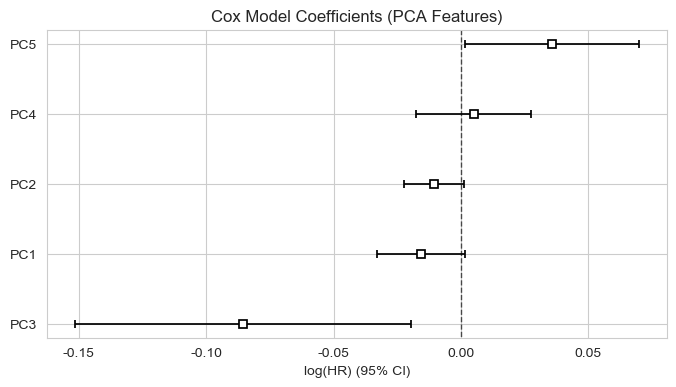


-- 绘制 Kaplan-Meier 生存曲线 --
按 'context_col_used' 分组...
KM 曲线图已保存为 /Users/yaoyue/stat 479/tcga_visualization/kaplan_meier_survival_curve.png


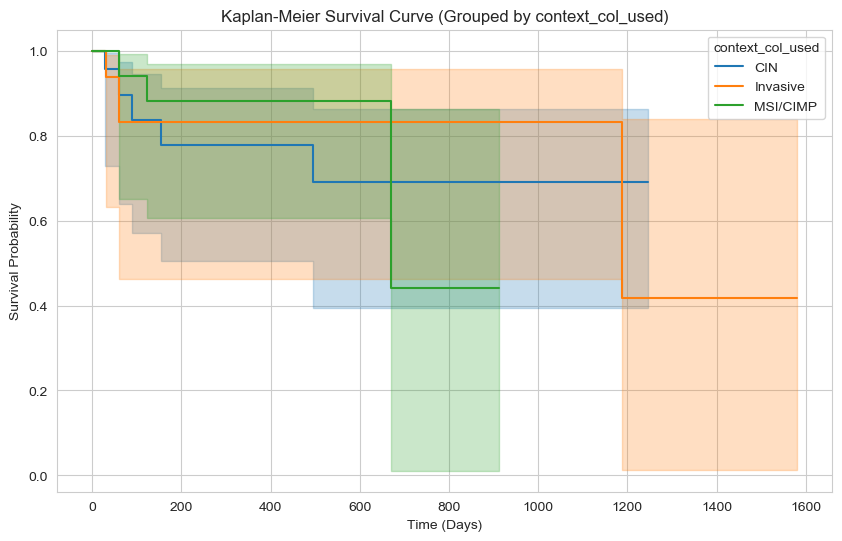

In [27]:
# 任务 8：评估 - 生存预测 (PCA 特征 + CV + 系数可视化)
survival_analysis_possible = False; survival_analysis_data = pd.DataFrame(); pca_features_df = pd.DataFrame(); cv_c_index_pca = np.nan; cph_final_pca = None
if lifelines_installed:
    death_col = 'days_to_death'; followup_col = 'days_to_last_followup'; status_col = 'vital_status'; deceased_value = 'DECEASED'; alive_value = 'LIVING'; required_survival_cols = [death_col, followup_col, status_col]
    if all(col in clinical_aligned.columns for col in required_survival_cols):
        print("准备生存数据...");
        if context_column not in clinical_aligned.columns: clinical_aligned[context_column] = 'all_samples'; print("警告：使用单一上下文。")
        survival_df = clinical_aligned[required_survival_cols + [context_column]].copy(); survival_df[death_col] = pd.to_numeric(survival_df[death_col], errors='coerce'); survival_df[followup_col] = pd.to_numeric(survival_df[followup_col], errors='coerce')
        survival_df['duration'] = survival_df[death_col].fillna(survival_df[followup_col]); survival_df['event'] = survival_df[status_col].apply(lambda x: 1 if isinstance(x, str) and x.strip().upper() == deceased_value.upper() else (0 if isinstance(x, str) and x.strip().upper() == alive_value.upper() else np.nan))
        survival_df = survival_df.dropna(subset=['duration', 'event']); survival_df['event'] = survival_df['event'].astype(int); survival_df = survival_df[survival_df['duration'] > 0]
        if not survival_df.empty:
            print(f"准备好 {len(survival_df)} 样本。"); print("准备 PCA 特征...")
            all_processed_df_list = [df for df in log_corrected_data_dict.values() if not df.empty] if 'log_corrected_data_dict' in globals() else []
            if all_processed_df_list:
                all_processed_df = pd.concat(all_processed_df_list); all_processed_df = all_processed_df.loc[~all_processed_df.index.duplicated(keep='first')]
                common_pca_samples = survival_df.index.intersection(all_processed_df.index)
                if len(common_pca_samples) >= 5:
                    X_for_pca = all_processed_df.loc[common_pca_samples].apply(pd.to_numeric, errors='coerce').fillna(0); temp_scaler = StandardScaler(); X_scaled_pca = temp_scaler.fit_transform(X_for_pca)
                    n_pca_components = 5; pca = PCA(n_components=n_pca_components)
                    try:
                        X_pca = pca.fit_transform(X_scaled_pca); pca_features_df = pd.DataFrame(X_pca, index=common_pca_samples, columns=[f'PC{i+1}' for i in range(n_pca_components)]); print(f"生成 {n_pca_components} 个 PCA 特征。")
                        survival_analysis_data = pd.merge(survival_df[['duration', 'event', context_column]], pca_features_df, left_index=True, right_index=True, how='inner').dropna()
                        if survival_analysis_data.shape[0] >= 10: print(f"最终用于 CV 样本数: {survival_analysis_data.shape[0]}"); survival_analysis_possible = True
                        else: print("错误：合并后样本过少 (<10)。")
                    except Exception as e: print(f"PCA 失败: {e}")
                else: print("错误：PCA 共同样本过少。")
            else: print("错误：无处理后数据用于 PCA。")
            if survival_analysis_possible:
                print("\n开始 5 折 CV (PCA 特征)..."); kf = KFold(n_splits=5, shuffle=True, random_state=42); cv_c_indices = []; features_for_cox = pca_features_df.columns.tolist(); fold_num = 1
                for train_index, test_index in kf.split(survival_analysis_data):
                    train_cv = survival_analysis_data.iloc[train_index]; test_cv = survival_analysis_data.iloc[test_index]
                    if test_cv['event'].nunique() < 2 or test_cv.shape[0] < 2: fold_num += 1; continue
                    if train_cv['event'].sum() < 2 or train_cv.shape[0] < 5 : fold_num += 1; continue
                    cph_cv = CoxPHFitter()
                    try:
                        cph_cv.fit(train_cv[['duration', 'event'] + features_for_cox], duration_col='duration', event_col='event')
                        pred_hazards_cv = -cph_cv.predict_partial_hazard(test_cv[features_for_cox])
                        c_index_fold = concordance_index(test_cv['duration'], pred_hazards_cv, test_cv['event']); cv_c_indices.append(c_index_fold)
                    except Exception as e: print(f" Fold {fold_num} 出错: {e}")
                    fold_num += 1
                if cv_c_indices: mean_c_index = np.mean(cv_c_indices); std_c_index = np.std(cv_c_indices); print(f"\nPCA 特征 CV 平均 C-index: {mean_c_index:.4f} +/- {std_c_index:.4f}"); cv_c_index_pca = mean_c_index
                else: print("\n未能计算 C-index。"); survival_analysis_possible = False
            if survival_analysis_possible:
                 print("\n拟合最终 PCA 模型..."); cph_final_pca = CoxPHFitter()
                 try:
                     if not all(f in survival_analysis_data.columns for f in features_for_cox): raise ValueError("缺少PCA特征列")
                     cph_final_pca.fit(survival_analysis_data[['duration', 'event'] + features_for_cox], duration_col='duration', event_col='event')
                     print("摘要:"); cph_final_pca.print_summary(decimals=4)
                     print("\n-- 可视化 PCA 模型系数 --"); plt.figure(figsize=(8, 4))
                     try: cph_final_pca.plot(); plt.title("Cox Model Coefficients (PCA Features)"); coef_pca_filename = os.path.join(output_visualization_dir, "cox_coefficients_pca.png"); plt.savefig(coef_pca_filename, dpi=100, bbox_inches='tight'); print(f"PCA 系数图已保存为 {coef_pca_filename}"); plt.show()
                     except Exception as plot_e: print(f"绘图失败: {plot_e}"); plt.close()
                 except Exception as e: print(f"拟合最终 PCA 模型出错: {e}"); cph_final_pca = None
                 print("\n-- 绘制 Kaplan-Meier 生存曲线 --"); plt.figure(figsize=(10, 6)); kmf = KaplanMeierFitter(); ax = plt.gca()
                 unique_contexts_in_survival = survival_analysis_data[context_column].nunique()
                 if context_column in survival_analysis_data and unique_contexts_in_survival > 1:
                      print(f"按 '{context_column}' 分组...");
                      for name, grouped_df in survival_analysis_data.groupby(context_column):
                          if len(grouped_df) > 0: kmf.fit(grouped_df["duration"], grouped_df["event"], label=str(name)); kmf.plot_survival_function(ax=ax)
                      plt.title(f"Kaplan-Meier Survival Curve (Grouped by {context_column})"); plt.legend(title=context_column)
                 else: print("绘制总体..."); kmf.fit(survival_analysis_data["duration"], survival_analysis_data["event"], label="Overall Survival"); kmf.plot_survival_function(ax=ax); plt.title("Overall Kaplan-Meier Survival Curve")
                 plt.xlabel("Time (Days)"); plt.ylabel("Survival Probability"); plt.grid(True); km_filename = os.path.join(output_visualization_dir, "kaplan_meier_survival_curve.png"); plt.savefig(km_filename, dpi=100, bbox_inches='tight'); print(f"KM 曲线图已保存为 {km_filename}"); plt.show()
            else: print("无法拟合最终模型或绘图。")
        else: print("错误：无有效生存数据。")
    else: print(f"警告：缺少生存列。")
else: print("警告：未安装 lifelines。")
if not survival_analysis_possible: print("\n无法执行 PCA 生存分析。")

准备仅包含临床特征的数据...
找到年龄列: 'age_at_initial_pathologic_diagnosis'
找到分期列: 'tumor_stage'
填充分期列 'stage_numeric' 中的缺失值为中位数: 2.0
使用处理后的分期列 'stage_numeric'。
最终用于临床模型的特征: ['age_at_initial_pathologic_diagnosis', 'stage_numeric']
最终用于临床模型的样本数: 111

开始进行 5 折交叉验证 (临床特征)...

仅临床特征模型 5 折交叉验证平均 C-index: 0.7199 +/- 0.1402

在完整数据上拟合最终临床特征模型...
最终临床模型拟合摘要:


<lifelines.CoxPHFitter: fitted with 111 total observations, 95 right-censored observations>
             duration col = 'duration'
                event col = 'event'
      baseline estimation = breslow
   number of observations = 111
number of events observed = 16
   partial log-likelihood = -56.9081
         time fit was run = 2025-04-30 17:55:09 UTC

---
                                      coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                                             
age_at_initial_pathologic_diagnosis 0.0295    1.0300    0.0230         -0.0155          0.0745              0.9846              1.0773
stage_numeric                       0.8477    2.3342    0.2934          0.2727          1.4227              1.3135              4.1483

                                     cmp to      z      p  -log2(p)
covariate                                                          
age_at_initial_pathologic_diagnosis  0.0000 1.2860 0.1985    2.3331
stage_numeric                        0.0000 2.8894 0.0039    8.0171
---
Concordance = 0.6765
Partial AIC = 117.8163
log-likelihood ratio test = 10.2735 on 2 df
-log2(p) of ll-ratio test = 7.4108


-- 可视化临床模型系数 --
临床系数图已保存为 /Users/yaoyue/stat 479/tcga_visualization/cox_coefficients_clinical.png


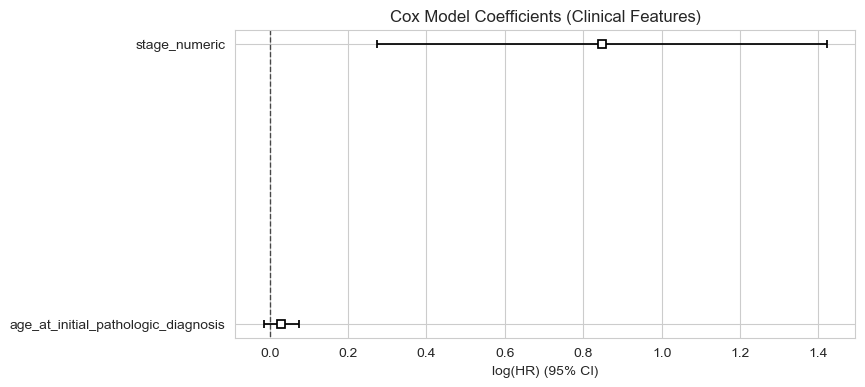


--- 模型性能比较 (基于 5 折 CV C-index) ---
交叉验证 C-index 比较:
PCA Features         0.842070
Clinical Features    0.719949
dtype: float64
结论：加入 PCA 特征提升了模型平均区分能力。
C-index 比较图已保存为 /Users/yaoyue/stat 479/tcga_visualization/cindex_comparison.png


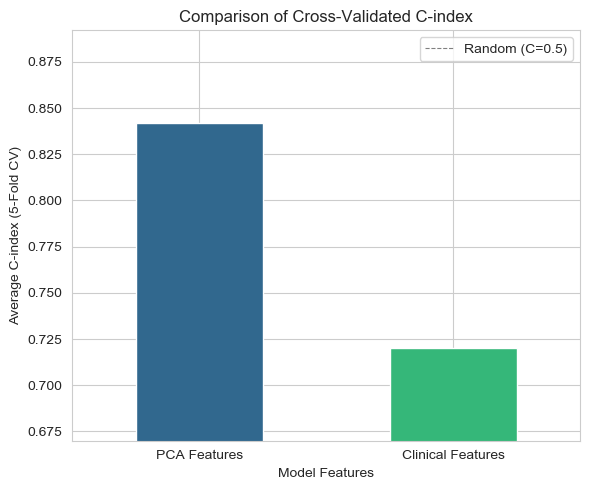

In [33]:
# 任务 14 (新)：模型比较 - 临床特征 vs PCA 特征 (加入交叉验证 + 系数可视化)
cv_c_index_clinical = np.nan # 初始化临床模型交叉验证 C-index
cph_final_clinical = None # 初始化最终模型变量

if (lifelines_installed and
    'survival_df' in globals() and isinstance(survival_df, pd.DataFrame) and not survival_df.empty and
    'clinical_aligned' in globals() and isinstance(clinical_aligned, pd.DataFrame) and not clinical_aligned.empty and
    'context_column' in globals() and isinstance(context_column, str) and
    'cv_c_index_pca' in globals() 
   ):

    print("准备仅包含临床特征的数据...")
    clinical_features_to_use = []
    if 'duration' not in survival_df.columns or 'event' not in survival_df.columns:
        print("错误：survival_df 中缺少 duration 或 event 列。")
    else:
        data_for_clinical_model = survival_df[['duration', 'event']].copy()

        # 定义可能的年龄和分期列名
        age_col = 'age_at_initial_pathologic_diagnosis'
        stage_col = 'tumor_stage'

        # 添加年龄特征
        if age_col in clinical_aligned.columns:
            print(f"找到年龄列: '{age_col}'")
            # 合并并确保数值类型
            data_for_clinical_model = data_for_clinical_model.merge(
                clinical_aligned[[age_col]].apply(pd.to_numeric, errors='coerce'),
                left_index=True, right_index=True, how='left'
            )
            # 填充缺失值
            if data_for_clinical_model[age_col].isnull().sum() > 0:
                mean_age = data_for_clinical_model[age_col].mean()
                if pd.notna(mean_age): # 确保均值有效
                    print(f"填充年龄列 '{age_col}' 中的缺失值为均值: {mean_age:.2f}")
                    data_for_clinical_model[age_col].fillna(mean_age, inplace=True)
                else:
                    print(f"警告：无法计算年龄均值进行填充，将删除包含 NaN 的行。")
            # 如果填充后仍有 NaN 或列本身无效，则不使用
            if age_col in data_for_clinical_model.columns and data_for_clinical_model[age_col].notna().all():
                 clinical_features_to_use.append(age_col)
            else:
                 print(f"警告：处理后年龄列 '{age_col}' 无效或仍含 NaN。")
                 if age_col in data_for_clinical_model.columns:
                     data_for_clinical_model = data_for_clinical_model.drop(columns=[age_col])
        else:
            print(f"警告：未在临床数据中找到年龄列 '{age_col}'。")

        # 添加分期特征
        if stage_col in clinical_aligned.columns:
             print(f"找到分期列: '{stage_col}'")
             def map_stage(stage):
                 if pd.isna(stage): return np.nan
                 stage_upper = str(stage).upper().replace('STAGE ', '')
                 if 'IV' in stage_upper: return 4
                 if 'III' in stage_upper: return 3
                 if 'II' in stage_upper: return 2
                 if 'I' in stage_upper: return 1
                 return np.nan
             stage_mapped_col = 'stage_numeric'
             # 确保索引对齐
             if data_for_clinical_model.index.isin(clinical_aligned.index).all():
                  data_for_clinical_model[stage_mapped_col] = clinical_aligned.loc[data_for_clinical_model.index, stage_col].apply(map_stage)
             else: # 如果索引不完全匹配
                  temp_stage = clinical_aligned.loc[data_for_clinical_model.index.intersection(clinical_aligned.index), stage_col].apply(map_stage)
                  data_for_clinical_model = data_for_clinical_model.merge(temp_stage.rename(stage_mapped_col), left_index=True, right_index=True, how='left')

             # 填充缺失值
             if data_for_clinical_model[stage_mapped_col].isnull().sum() > 0:
                 median_stage = data_for_clinical_model[stage_mapped_col].median()
                 if pd.notna(median_stage):
                     print(f"填充分期列 '{stage_mapped_col}' 中的缺失值为中位数: {median_stage}")
                     data_for_clinical_model[stage_mapped_col].fillna(median_stage, inplace=True)
                 else:
                     print(f"警告：无法计算分期中位数进行填充。")

             # 再次检查是否有效
             if stage_mapped_col in data_for_clinical_model.columns and data_for_clinical_model[stage_mapped_col].notna().all():
                data_for_clinical_model[stage_mapped_col] = data_for_clinical_model[stage_mapped_col].astype(int)
                clinical_features_to_use.append(stage_mapped_col)
                print(f"使用处理后的分期列 '{stage_mapped_col}'。")
             else:
                print(f"警告：处理后分期列 '{stage_mapped_col}' 无效或仍含 NaN。")
                if stage_mapped_col in data_for_clinical_model.columns:
                     data_for_clinical_model = data_for_clinical_model.drop(columns=[stage_mapped_col])
        else:
             print(f"警告：未在临床数据中找到分期列 '{stage_col}'。")

        # 清理数据：最后删除包含任何 NaN 的行
        final_cols_to_check = ['duration', 'event'] + clinical_features_to_use
        rows_before_dropna = data_for_clinical_model.shape[0]
        data_for_clinical_model = data_for_clinical_model.dropna(subset=final_cols_to_check)
        rows_after_dropna = data_for_clinical_model.shape[0]
        if rows_before_dropna > rows_after_dropna:
            print(f"因 NaN 值移除了 {rows_before_dropna - rows_after_dropna} 行数据。")

        print(f"最终用于临床模型的特征: {clinical_features_to_use}")
        print(f"最终用于临床模型的样本数: {data_for_clinical_model.shape[0]}")

        # 交叉验证 
        if clinical_features_to_use and data_for_clinical_model.shape[0] >= 10 and data_for_clinical_model['event'].sum() >= 2:
            print("\n开始进行 5 折交叉验证 (临床特征)...")
            kf_clin = KFold(n_splits=5, shuffle=True, random_state=42)
            cv_c_indices_clinical = []
            # 确保只使用数值型特征
            numeric_clinical_features = data_for_clinical_model[clinical_features_to_use].select_dtypes(include=np.number).columns.tolist()

            if numeric_clinical_features:
                fold_num = 1
                for train_index, test_index in kf_clin.split(data_for_clinical_model):
                    train_cv_clin = data_for_clinical_model.iloc[train_index]
                    test_cv_clin = data_for_clinical_model.iloc[test_index]

                    # 检查训练集和测试集
                    if test_cv_clin['event'].nunique() < 2 or test_cv_clin.shape[0] < 2:
                        # print(f"    Fold {fold_num}: 测试集事件状态单一或样本过少，跳过。") # 可选打印
                        fold_num += 1; continue
                    if train_cv_clin['event'].sum() < 2 or train_cv_clin.shape[0] < 5 :
                        # print(f"    Fold {fold_num}: 训练集事件数或样本量不足，跳过。") # 可选打印
                        fold_num += 1; continue

                    cph_cv_clin = CoxPHFitter()
                    try:
                        # 检查训练特征方差
                        if train_cv_clin[numeric_clinical_features].var().sum() == 0:
                             print(f"    Fold {fold_num}: 训练特征方差为零，跳过。")
                             fold_num += 1; continue

                        cph_cv_clin.fit(train_cv_clin[['duration', 'event'] + numeric_clinical_features], duration_col='duration', event_col='event')
                        # 检查测试集是否有对应特征
                        if not all(f in test_cv_clin.columns for f in numeric_clinical_features):
                             print(f"    Fold {fold_num}: 测试集缺少特征，跳过。")
                             fold_num += 1; continue

                        pred_hazards_cv_clin = -cph_cv_clin.predict_partial_hazard(test_cv_clin[numeric_clinical_features])
                        c_index_fold_clin = concordance_index(test_cv_clin['duration'], pred_hazards_cv_clin, test_cv_clin['event'])
                        cv_c_indices_clinical.append(c_index_fold_clin)
                    except Exception as e:
                        print(f"    Fold {fold_num} 出错: {e}")
                    fold_num += 1 # 确保 fold_num 增加

                if cv_c_indices_clinical:
                    mean_c_index_clin = np.mean(cv_c_indices_clinical)
                    std_c_index_clin = np.std(cv_c_indices_clinical)
                    print(f"\n仅临床特征模型 5 折交叉验证平均 C-index: {mean_c_index_clin:.4f} +/- {std_c_index_clin:.4f}")
                    cv_c_index_clinical = mean_c_index_clin # 存储平均值
                else:
                    print("\n未能成功计算任何折的临床模型 C-index。")
            else:
                print("在处理后的数据中没有可用的数值型临床特征进行交叉验证。")

            # 拟合最终模型 & 可视化系数
            if clinical_features_to_use and data_for_clinical_model.shape[0] >= 5:
                 print("\n在完整数据上拟合最终临床特征模型...")
                 cph_final_clinical = CoxPHFitter()
                 try:
                      numeric_clinical_features = data_for_clinical_model[clinical_features_to_use].select_dtypes(include=np.number).columns.tolist()
                      if not numeric_clinical_features: raise ValueError("无数值临床特征")

                      cph_final_clinical.fit(data_for_clinical_model[['duration', 'event'] + numeric_clinical_features], duration_col='duration', event_col='event')
                      print("最终临床模型拟合摘要:")
                      cph_final_clinical.print_summary(decimals=4)

                      # 可视化临床模型系数 
                      print("\n-- 可视化临床模型系数 --")
                      plt.figure(figsize=(8, max(4, len(numeric_clinical_features)*1.5))) # 调整高度
                      try:
                          cph_final_clinical.plot() # 绘制系数图
                          plt.title("Cox Model Coefficients (Clinical Features)")
                          coef_clin_filename = os.path.join(output_visualization_dir, "cox_coefficients_clinical.png")
                          plt.savefig(coef_clin_filename, dpi=100, bbox_inches='tight')
                          print(f"临床系数图已保存为 {coef_clin_filename}")
                          plt.show()
                      except Exception as plot_e:
                          print(f"绘制临床模型系数图失败: {plot_e}")
                          plt.close() # 出错时关闭

                 except Exception as e:
                      print(f"拟合最终临床模型时出错: {e}")
                      cph_final_clinical = None # 拟合失败则设为 None

            # 模型比较 & 可视化
            print("\n--- 模型性能比较 (基于 5 折 CV C-index) ---")
            comparison_data = {}
            # 确保 cv_c_index_pca 在全局作用域中被定义
            if 'cv_c_index_pca' in globals() and not np.isnan(cv_c_index_pca):
                 comparison_data['PCA Features'] = cv_c_index_pca
            if not np.isnan(cv_c_index_clinical):
                 comparison_data['Clinical Features'] = cv_c_index_clinical

            if len(comparison_data) >= 1: # 至少有一个结果才能画图或比较
                comparison_series = pd.Series(comparison_data)
                print("交叉验证 C-index 比较:")
                print(comparison_series)

                if len(comparison_data) == 2: # 只有两个都有结果才做比较说明
                    if comparison_data['PCA Features'] > comparison_data['Clinical Features']: print("结论：加入 PCA 特征提升了模型平均区分能力。")
                    elif comparison_data['PCA Features'] < comparison_data['Clinical Features']: print("结论：仅临床特征模型平均区分能力更好。")
                    else: print("结论：两种模型平均区分能力相当。")

                # 绘制比较图
                plt.figure(figsize=(6, 5))
                try:
                    comparison_series.plot(kind='bar', color=sns.color_palette("viridis", len(comparison_series)))
                    plt.axhline(y=0.5, color='grey', linestyle='--', linewidth=0.8, label='Random (C=0.5)')
                    plt.title('Comparison of Cross-Validated C-index')
                    plt.ylabel('Average C-index (5-Fold CV)')
                    plt.xlabel('Model Features')
                    plt.xticks(rotation=0)
                    # 动态调整 Y 轴范围，确保 0.5 在可见范围内
                    min_val = comparison_series.min() if not comparison_series.empty else 0.4
                    max_val = comparison_series.max() if not comparison_series.empty else 0.6
                    plt.ylim(bottom=max(0, min_val - 0.05), top=min(1, max_val + 0.05))
                    plt.legend()
                    plt.tight_layout()
                    cindex_comp_filename = os.path.join(output_visualization_dir, "cindex_comparison.png")
                    plt.savefig(cindex_comp_filename, dpi=100)
                    print(f"C-index 比较图已保存为 {cindex_comp_filename}")
                    plt.show()
                except Exception as e:
                    print(f"绘制 C-index 比较图失败: {e}")
                    plt.close() # 出错时确保关闭

            else:
                print("未能获取到足够模型的 CV C-index 结果，无法比较或绘图。")
                if 'PCA Features' not in comparison_data: print("(PCA CV 结果缺失)")
                if 'Clinical Features' not in comparison_data: print("(临床 CV 结果缺失)")

        else: # clinical_features_to_use 为空或数据不足时
            print("没有足够的临床特征或数据来拟合和交叉验证基线模型。")

else:
    print("依赖缺失 (lifelines/survival_df/clinical_aligned/context_column/cv_c_index_pca)，无法进行模型比较。")


-- 使用上下文 'MSI/CIMP' 的模型进行推断 --
推理引擎初始化成功。
随机选择: 查询='AC022447.1', 证据='AC008626.2'
查询: P(AC022447.1 | AC008626.2=0)
推断结果:
+---------------+-------------------+
| AC022447.1    |   phi(AC022447.1) |
+===============+===================+
| AC022447.1(0) |            0.9435 |
+---------------+-------------------+
| AC022447.1(2) |            0.0565 |
+---------------+-------------------+
推断结果图已保存为 /Users/yaoyue/stat 479/tcga_visualization/inference_AC022447.1_given_AC008626.2_MSI_CIMP.png


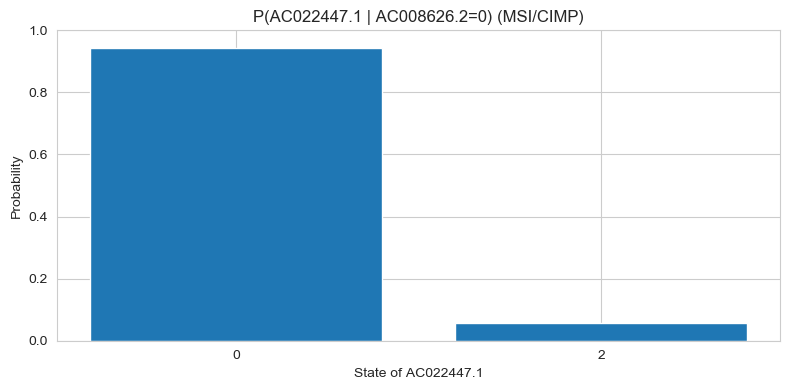


--- 分析流程结束 ---


In [35]:
# 任务 11: 推断示例
if 'learned_models' in globals() and learned_models:
     if not learned_models: print("没有成功学习的模型。")
     else:
        context_to_infer = list(learned_models.keys())[0]; model_infer = learned_models[context_to_infer]
        print(f"\n-- 使用上下文 '{context_to_infer}' 的模型进行推断 --")
        nodes_in_model = list(model_infer.nodes())
        if len(nodes_in_model) >= 2:
            try: inference_engine = VariableElimination(model_infer); print("推理引擎初始化成功。")
            except Exception as e: print(f"错误：初始化推理引擎失败: {e}"); inference_engine = None
            if inference_engine is not None:
                try:
                    selected_nodes = np.random.choice(nodes_in_model, 2, replace=False); query_var = selected_nodes[0]; evidence_var = selected_nodes[1]
                    print(f"随机选择: 查询='{query_var}', 证据='{evidence_var}'")
                    evidence_cpd = model_infer.get_cpds(evidence_var)
                    if evidence_cpd is not None and evidence_var in evidence_cpd.state_names:
                        evidence_states = evidence_cpd.state_names[evidence_var]
                        if len(evidence_states) > 0:
                            evidence_val = evidence_states[0]; print(f"查询: P({query_var} | {evidence_var}={evidence_val})"); evidence_dict = {evidence_var: int(evidence_val)}
                            query_result = inference_engine.query(variables=[query_var], evidence=evidence_dict, show_progress=False)
                            print("推断结果:"); print(query_result)
                            plt.figure(figsize=(8, 4)); query_states = query_result.state_names[query_var]; query_probs = query_result.values; state_labels = [str(s) for s in query_states]
                            plt.bar(state_labels, query_probs); plt.title(f"P({query_var} | {evidence_var}={evidence_val}) ({context_to_infer})"); plt.xlabel(f"State of {query_var}"); plt.ylabel("Probability"); plt.ylim(0, 1); plt.tight_layout()
                            safe_context_name = str(context_to_infer).replace('/', '_').replace('\\', '_'); inf_filename = os.path.join(output_visualization_dir, f"inference_{query_var}_given_{evidence_var}_{safe_context_name}.png")
                            plt.savefig(inf_filename, dpi=100); print(f"推断结果图已保存为 {inf_filename}"); plt.show()
                        else: print(f"变量 '{evidence_var}' 没有定义状态。")
                    else: print(f"无法获取变量 '{evidence_var}' 的CPD。")
                except Exception as e: print(f"推断失败: {e}")
        else: print(f"模型中变量不足 (<2)。")
else: print("没有学习到模型。")
print("\n--- 分析流程结束 ---")